# Deferred Revenue Forecast

This jupyter notebook contains the details Adobe's deferred revenue forecast model in a more readable, easy to understand format.

The program is run from python directly (versus using a notebook like we have here) and the details are available on my github page www.github.com/davidjsmith44/Deferred_Revenue_Forecast
Note: You will need me to give you access to this repository as it is not public

<b>This is bold text </b>

<i>Italic Text </i>

<blockquote> This is where I have my blockquote text. It will all be indented to make it easier to read </blockquote>

This is not blockquote, but below is a horizontal line
___

<b> Step 1: Process the Base Billings Data </B>


Steps to the program
1. Load up all input data
    - billings history
        - Type A
    - FX rates
    - FX_currency map
    - FX forwards
    - bookings data
 
 
 2. Process the billings data into a dataframe that includes the BU, currency, period and every type of billings based on it's rebill frequency
 
 3. Process the bookings information

4. Forecast the future billings

5. Basic reporting documents

6. Checking for sanity


NOTE: If you plan on using a Jupyter Notebook to run the Deferred Revenue Forecast, you must first download all of the input data to your local directory. I do not yet know how to use a Jupyter Notebook and access data off of the Treasury server.

The input data sits on the Treasury server under Treasury\Financial_Database\Deferred_Revenue\Inputs\Data_YYYY_pMM

There will be 6 files located at this directory that need to be copied to your local drive (preferably where you have installed Anaconda) under a directory called data

## Code Begins here
Below are standard import statements to include all the functionality of numpy, pandas, matplotlib, pickle and a linear regression moodel from sklearn.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import pickle
from math import ceil
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d, griddata

## Step 1: Processing Base Billings Data

The billings data comes from tableau and is saved in a file "all_billings_inputs.xlsx" with two sheets of information

"base_billings"
Contains the basic information about all of the billings

In [2]:
df = pd.read_excel('../data/all_billings_inputs.xlsx', sheet_name='base_billings')

###### Changing the column names early since they are inconsistent across other reports

In [3]:
df.rename(index = str, columns = {'Document Currency': 'curr',
                                 'Enterprise BU Desc': 'BU',
                                 'Invoice Fiscal Year Period Desc': 'period',
                                 'Product Config Type': 'config',
                                 'Rev Rec Category': 'rev_req_type',
                                 'Rule For Bill Date': 'rebill_rule',
                                 'Completed Sales ( DC )': 'DC_amount',
                                 'Completed Sales': 'US_amount'}, inplace=True)

### To inspect the dataframe we just loaded, you can remove the '#' symbol from the rows below. The # symbol makes the line of code a comment (so the program will not read and execute that line of code). Removing the # will make the line executable and display the results

The df.head(5) command will show the first 5 rows of the billings dataframe. To run this, simply remove the # before this line
 
The df.tail(5) command will show the last 5 rows of the billings dataframe. To run this, simply remove the # before this line

The df.sample(5) command will show a random 5 rows of the rec dataframe. To run this, simply remove the # before this line

Note 1: Only one of these commands can be entered in a single code cell at a time. (So if you remove 2 of the #, only one of the commands will be displayed.

Note 2: The 5 can also be changed, but I think it caps out at 100. For example df.head(30) will show the first 30 rows of the billings dataframe.

Note 3: The code must sit on the far leftmost column of the code window. If there is a space it will cause an error.

In [4]:
#df.head(5)
#df.tail(5)
#df.sample(5)

### Filtering out any currency that has  < 10 transactions. 
###### To see the list of currencies and how any times they appear in the billings database remove the # before the print(vc) statement

In [5]:
# creates a list of the currencies and the number of transactions for each currency
vc = df['curr'].value_counts()
#print(vc)

#Create variable that is true if the number of transaction is greater than 10, false otherwise
keep_these = vc.values > 10
# filtering only currencies that were greater than 10
keep_curr = vc[keep_these]
a = keep_curr.index

#### Just keeping track of the currencies we removed in our model_dict data structure

In [6]:
remove_these = vc[vc.values <= 10].index
model_dict = {'curr_removed': list(vc[remove_these].index)}
delete_curr = list(remove_these)
print(model_dict)

{'curr_removed': ['SAR', 'BMD', 'MXP', 'AED']}


#### The FX database does not have information on the following currencies
 - AED (United Arab Emirates Dirham)
 - BMD (Bermudan Dollar)
 - MXP (Mexican Peso)
 - TRY (Turkish Lira)
 
 Below we are adding the Turkish Lira to our list of currencies that should be removed from the dataframe

In [7]:
if 'TRY' not in model_dict['curr_removed']:
    model_dict['curr_removed'].append('TRY')
    delete_curr.append('TRY')
    a = a.drop('TRY')


###### Clearing out the infrequent currencies from our billings data

In [8]:
df = df[df['curr'].isin(a)]

print('Model dictionary', model_dict)

Model dictionary {'curr_removed': ['SAR', 'BMD', 'MXP', 'AED', 'TRY']}


In [9]:
print("---Removing infrequent currencies from billings history---")
print('Total number of currencies in the base billings file: ', len(vc))
if len(model_dict['curr_removed'])==0:
    print('No currencies were removed, all contained 10 or more billings')
    print('Currencies in the base billings file')
    for item in a:
        print(a[item], end = " ")
else:
    print('\n Currencies were removed: ', len(model_dict['curr_removed']))

    for item in remove_these:
        print(item, ', ', end="")
        
    print("\n\n{} Remaining currencies: ".format(len(a)))
    for item in a:
        print(item, ', ', end="")

---Removing infrequent currencies from billings history---
Total number of currencies in the base billings file:  32

 Currencies were removed:  5
SAR , BMD , MXP , AED , 

27 Remaining currencies: 
USD , EUR , GBP , AUD , JPY , CHF , SEK , DKK , NOK , CAD , HKD , BRL , RUB , KRW , CLP , ARS , COP , SGD , PEN , INR , PHP , TWD , THB , MYR , IDR , NZD , ILS , 

#### Removing any of the values that are zero

In [10]:
print('This is the length of the dataframe before removing zeros: ', len(df))
df = df[df['DC_amount']!=0]
print('This is the length of the dataframe after removing zeros: ', len(df))

This is the length of the dataframe before removing zeros:  49737
This is the length of the dataframe after removing zeros:  46258


In [11]:
#df.head(10)
#df.tail(10)
#df.sample(10)

#### Clearing out the Non-Revenue billings from the file
 

In [12]:
df["Sales Type"].value_counts()

DEFERRED       37601
RECOGNIZED      7183
PRO-SVC-INV     1323
NON-REV          150
Name: Sales Type, dtype: int64

In [13]:
print('Length of the dataframe before removing non-revenue billings: ', len(df))
df = df[df['Sales Type']!='NON-REV']
print('Length of the dataframe after removing non-revenue billings:  ', len(df))

Length of the dataframe before removing non-revenue billings:  46258
Length of the dataframe after removing non-revenue billings:   46108



## Grouping the billings by sales type

Grouping the data by the <b> Sales Type </b> field
 - <i>'RECOGNIZED'</i> sales are perpetual and go straight to revenue without hitting deferred 
 - <i>'PRO-SVC-INV'</i> professional services that are invoiced and go to revenue directly when invoiced
 - <i>'DEFERRED'</i> sales that will sit on the balance sheet in deferred revenue and amortize over their life
 
 #### Below we are creating a seperate dataframe for each of the Sales Types


In [14]:
rec = df[df['Sales Type']=='RECOGNIZED'].copy()
svc = df[df['Sales Type']=='PRO-SVC-INV'].copy()
dfr = df[df['Sales Type']=='DEFERRED'].copy()

print('Total number of billings:              ', len(df))
print("Number of recognized revenue billings: ", len(rec))
print("Number of service invoiced billings:   ", len(svc))
print("Number of deferred revenue billings:   ", len(dfr))

Total number of billings:               46108
Number of recognized revenue billings:  7183
Number of service invoiced billings:    1323
Number of deferred revenue billings:    37601


### Recognized Revenue

The rec.head(5) command will show the first 5 elements of the rec dataframe. To run this, simply remove the # before this line
 
The rec.tail(5) command will show the last 5 elements of the rec dataframe. To run this, simply remove the # before this line

The rec.sample(5) command will show the a random 5 elements of the rec dataframe. To run this, simply remove the # before this line

Note: Only one of these commands can be entered in a single code cell at a time. 

Note: The 5 can also be changed, but I think it caps out at 100

In [15]:
#rec.head(5)
#rec.tail(5)
#rec.sample(5)

##### Below we are grouping the rec dataframe by Currency, Business Unit and Period and cleaning up the data we do not need. Since the recognized revenue go directly to revenue, there is no contract that will renew and need to be modeled in the future.

In [16]:
# testing groupby object
gb_rec = rec.groupby(['curr', 'BU', 'period'], as_index=False).sum()
gb_rec.drop(labels='Subscription Term', axis=1,inplace =True)

In [17]:
#gb_rec.head(10)
#gb_rec.tail(10)
#gb_rec.sample(10)

### Service Billings

##### Below we are grouping the svc dataframe by Currency, Business Unit and Period and cleaning up the data we do not need. Since the service billings go directly to revenue, there is no contract that will renew and need to be modeled in the future.

In [18]:
gb_svc = svc.groupby(['curr', 'BU', 'period'], as_index=False).sum()
gb_svc.drop(labels='Subscription Term', axis=1,inplace =True)

In [19]:
#gb_svc.head(5)
#gb_svc.tail(5)
#gb_svc.sample(5)

### Deffered Billings

#### Type B Billings 
Type B billings are service agreements that will have invoices submitted before the billings are reclassified to revenue. If no invoices are assigned to the billings, the billings become revenue in 12 months. Since these billings do not have a contract that will renew in the future, there is no need to model a rebillings of these service based billings


In [20]:
dfr_b = dfr[dfr['rev_req_type']=='B'].copy()
gb_b = dfr_b.groupby(['curr', 'BU', 'period'], as_index=False).sum()
gb_b.drop(labels='Subscription Term', axis=1, inplace=True)

In [21]:
#gb_b.head(5)
#gb_b.tail(25)
#gb_b.sample(5)

#### Type A Billings

These billings are on a billing plan. The product config tells us how long before they renew

 - '3Y' = 36 months
 - '2Y' = 24 months
 - '1Y' = 12 months
 - 'MTHLY' = 1 month
 
NOTE: There are also other fields in the 'Product Configtype ID' field that do not map well to a rebill period.
To fix this, we need to load up a different file and determine the length of the sales contract (type A no config)


In [22]:
dfr_a = dfr[dfr['rev_req_type']=='A'].copy()

gb_a = dfr_a.groupby(['curr', 'BU', 'period',
                     'config'], as_index=False).sum()
gb_a.drop(labels='Subscription Term', axis=1, inplace = True)

In [23]:
#gb_a.head(20)
#gb_a.tail(20)
#gb_a.sample(20)

In [24]:
gb_a['config'].value_counts()

1Y       2418
MTHLY     950
2Y        875
OUNIV     231
OCONS     106
3Y        101
ONORE      32
OENSV       1
1V          1
Name: config, dtype: int64

#### Below is just a check to see how large the billing types are across all periods

In [25]:
gb_a_config = gb_a.groupby(['config'], as_index=False).sum()
gb_a_config

,config,DC_amount,US_amount
0,1V,6.503000e+03,6.503000e+03
1,1Y,1.198135e+11,9.655797e+09
2,2Y,2.470307e+08,6.719101e+07
3,3Y,9.380464e+08,4.051346e+06
4,MTHLY,1.381940e+08,3.985406e+07
5,OCONS,3.903233e+07,1.028252e+07
6,OENSV,-1.200000e+02,-1.200000e+02
7,ONORE,2.350904e+06,2.015485e+06
8,OUNIV,4.283761e+06,3.473767e+06


###### These 'OCONS', 'OENSV', 'ONORE' and 'OUNIV' config types are not actual product config IDs so we have to get them from a different data file. We are excluding these types below.

In [26]:
config_list = ['1Y', '2Y', '3Y', 'MTHLY']
gb_a_config = gb_a[gb_a['config'].isin(config_list)]

###### Grouping by the config type into gb_a_1Y, gb_a_2Y, gb_a_3y, gb_a_1M dataframes


In [27]:
gb_a_1Y = gb_a_config[gb_a_config['config']=='1Y'].copy()
gb_a_2Y = gb_a_config[gb_a_config['config']=='2Y'].copy()
gb_a_3Y = gb_a_config[gb_a_config['config']=='3Y'].copy()
gb_a_1M = gb_a_config[gb_a_config['config']=='MTHLY'].copy()

In [28]:
print('this is the lenght of type A 1M billings: ', len(gb_a_1M))
print('this is the lenght of type A 1Y billings: ', len(gb_a_1Y))
print('this is the lenght of type A 2Y billings: ', len(gb_a_2Y))
print('this is the lenght of type A 3Y billings: ', len(gb_a_3Y))

this is the lenght of type A 1M billings:  950
this is the lenght of type A 1Y billings:  2418
this is the lenght of type A 2Y billings:  875
this is the lenght of type A 3Y billings:  101


In [29]:
#gb_a_2Y.head(5)
#gb_a_1M.tail(5)
#gb_a_3Y.sample(5)

#### TYPE D billings
These billings have a field 'Rule For Bill Date' that determines when new billings will occur
 - Monthly:        *{Y1, Y2, Y3, Y5}*
 - Quarterly:      *YQ*
 - Every 4 months: *YT*  --NOTE: There are only 10 of these, so I am treating these as quarterly--
 - Semi-annual:    *YH*
 - Annual:         *{YA, YC}*
 - Every 2 years:  *Y4*
 - Every 3 years:  *Y7*
 
 We also need to track the type D billings that do not have a 'Rule for Bill Date'

In [30]:
dfr_d = dfr[dfr['rev_req_type']=='D'].copy()

gb_d = dfr_d.groupby(['curr', 'BU', 'period',
                     'rebill_rule'], as_index=False).sum()
gb_d.drop(labels='Subscription Term', axis=1, inplace = True)

In [31]:
gb_d['rebill_rule'].value_counts()

YA    2946
Y3    2370
YQ     991
YH     547
Y1     491
YC     490
Y2     153
Y4      57
Y7      31
YM      23
YX      12
YY      10
YT      10
Name: rebill_rule, dtype: int64

###### Grouping these by rebill rule and incorporating rebill rules that have the same rebill period

In [32]:
gb_d_mthly = gb_d[gb_d['rebill_rule'].isin(['Y1', 'Y2', 'Y3', 'YM'])].copy()
gb_d_mthly.drop(labels='rebill_rule', axis=1,inplace=True)
gb_d_mthly = gb_d_mthly.groupby(['curr', 'BU', 'period']).sum()
gb_d_mthly.reset_index(inplace=True)

gb_d_qtrly = gb_d[gb_d['rebill_rule'].isin(['YQ', 'YY', 'YT'])].copy()
gb_d_qtrly.drop(labels='rebill_rule', axis=1,inplace=True)
gb_d_qtrly = gb_d_qtrly.groupby(['curr', 'BU', 'period']).sum()
gb_d_qtrly.reset_index(inplace=True)

gb_d_semi_ann = gb_d[gb_d['rebill_rule']=='YH']

gb_d_annual = gb_d[gb_d['rebill_rule'].isin(['YA', 'YC', 'YX'])].copy()
gb_d_annual.drop(labels='rebill_rule', axis=1,inplace=True)
gb_d_annual = gb_d_annual.groupby(['curr', 'BU', 'period']).sum()
gb_d_annual.reset_index(inplace=True)

gb_d_two_yrs = gb_d[gb_d['rebill_rule']=='Y4']
gb_d_three_yrs = gb_d[gb_d['rebill_rule']=='Y7']

In [33]:
#gb_d_qtrly.head(10)
#gb_d_annual.tail(10)
#gb_d_three_yrs.head(10)

In [34]:
print('Length of monthly', len(gb_d_mthly))
print('Length of quarterly', len(gb_d_qtrly))
print('Length of semi ann', len(gb_d_semi_ann))
print('Length of annual', len(gb_d_annual))
print('Length of two years', len(gb_d_two_yrs))
print('Length of three years', len(gb_d_three_yrs))

Length of monthly 2592
Length of quarterly 991
Length of semi ann 547
Length of annual 2946
Length of two years 57
Length of three years 31


## Building a single dataframe that incorporates all of this data

- We will have the following descriptive fields
   - Invoicing Fiscal Year-Period
   - Document Currency Billing Amount
   - USD Billing Amount
   - Enterprise BU

- We will have the following fields based on rebilling rule
   - Recognized
   - Service
   - Monthly
   - Quarterly
   - Annual
   - Two Years
   - Three Years

###### Below uses functions to merge a list of dataframes and move billings amounts to the correct category based on rebill frequency and type


In [35]:
list_df = [gb_rec, gb_svc, gb_b,
           gb_a_1M,    gb_a_1Y,    gb_a_2Y,       gb_a_3Y, 
           gb_d_mthly, gb_d_qtrly, gb_d_semi_ann, gb_d_annual, gb_d_two_yrs, gb_d_three_yrs]

list_columns = ['recognized', 'service', 'deferred_B', 
        'deferred_1M_a', 'deferred_1Y_a', 'deferred_2Y_a', 'deferred_3Y_a',
        'deferred_1M_d', 'deferred_3M_d', 'deferred_6M_d', 'deferred_1Y_d', 'deferred_2Y_d', 'deferred_3Y_d']


In [36]:
def sum_USD_amt(list_df, list_columns):
    total_US = []
    for df in list_df:
        total_US.append(df['US_amount'].sum())
    total_df = pd.DataFrame(index = list_columns, columns = ['US_amounts'], data=total_US)
    return total_df

In [37]:
def merge_all_dataframes(list_df, list_columns):
    for i, df in enumerate(list_df):
        #print('This is i:', i)
        #print('referencing the column: ', list_columns[i])

        if i==0:
            df_merged = list_df[0].copy()
            df_merged.rename(index=str, columns={'DC_amount': list_columns[i]+'_DC', 
                                                 'US_amount': list_columns[i]+'_US'}, inplace=True)
        else:
            df_merged = merge_new_dataframe(df_merged, df, list_columns[i])

    return df_merged
    

In [38]:
def merge_new_dataframe(old_df, new_df, new_column):
    df_merged = pd.merge(old_df, new_df, how='outer', 
                     left_on=['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'])
    df_merged.rename(index=str, columns={'DC_amount': new_column+'_DC', 'US_amount': new_column+'_US'}, inplace=True)
    
    #need to drop the product configtype id for merges where the new_df is of type A
    config_str = 'config'
    rule_str = 'rebill_rule'
    if config_str in df_merged.columns:
        df_merged.drop(columns=['config'], inplace=True)
    
    if rule_str in df_merged.columns:
        df_merged.drop(columns=['rebill_rule'], inplace=True)
        
    return df_merged

In [39]:
def clean_df_columns(df):
    
    # clean up NaNs before adding 
    df = df.fillna(value=0)
    
    # DC columns first
    # Monthly
    df['deferred_1M_DC'] = df['deferred_1M_a_DC']+df['deferred_1M_d_DC']
    df.drop(labels=['deferred_1M_a_DC', 'deferred_1M_d_DC'], axis=1, inplace=True)
    
    # Annual
    df['deferred_1Y_DC'] = df['deferred_1Y_a_DC']+df['deferred_1Y_d_DC']
    df.drop(labels=['deferred_1Y_a_DC', 'deferred_1Y_d_DC'], axis=1, inplace=True)
    
    # Two-Year
    df['deferred_2Y_DC'] = df['deferred_2Y_a_DC']+df['deferred_2Y_d_DC']
    df.drop(labels=['deferred_2Y_a_DC', 'deferred_2Y_d_DC'], axis=1, inplace=True)
    
    #Three-Year
    df['deferred_3Y_DC'] = df['deferred_3Y_a_DC']+df['deferred_3Y_d_DC']
    df.drop(labels=['deferred_3Y_a_DC', 'deferred_3Y_d_DC'], axis=1, inplace=True)
    
    # renaming 3M and 6M
    df.rename(index=str, columns = {'deferred_3M_d_DC':'deferred_3M_DC', 
                               'deferred_6M_d_DC': 'deferred_6M_DC'}, inplace=True)

    # US columns
    # Monthly
    df['deferred_1M_US'] = df['deferred_1M_a_US']+df['deferred_1M_d_US']
    df.drop(labels=['deferred_1M_a_US', 'deferred_1M_d_US'], axis=1, inplace=True)
    
    # Annual
    df['deferred_1Y_US'] = df['deferred_1Y_a_US']+df['deferred_1Y_d_US']
    df.drop(labels=['deferred_1Y_a_US', 'deferred_1Y_d_US'], axis=1, inplace=True)
    
    # Two-Year
    df['deferred_2Y_US'] = df['deferred_2Y_a_US']+df['deferred_2Y_d_US']
    df.drop(labels=['deferred_2Y_a_US', 'deferred_2Y_d_US'], axis=1, inplace=True)
    
    # Three-Year
    df['deferred_3Y_US'] = df['deferred_3Y_a_US']+df['deferred_3Y_d_US']
    df.drop(labels=['deferred_3Y_a_US', 'deferred_3Y_d_US'], axis=1, inplace=True)
    
    # renaming 3M and 6M
    df.rename(index=str, columns = {'deferred_3M_d_US':'deferred_3M_US', 
                               'deferred_6M_d_US': 'deferred_6M_US'}, inplace=True)

    
    #cleaning up the longer column names
    df.rename(index=str, columns = {'curr': 'curr',
                               'BU':'BU',
                               'period':'period'}, inplace=True)
    
    return df

##### The code below uses the functions above to merge all of the dataframes and clean up the columns

In [40]:
df = merge_all_dataframes(list_df, list_columns)

df = clean_df_columns(df)

## I NEED TO CREATE A BETTER PRESENTATION OF THIS CHECK THAT EVERYTHING MATCHES!!!!

## Need to create a summary report with totals coming from every area to make sure the totals I have make sense

In [41]:
df.sum()

curr              ARSARSARSARSARSARSARSARSARSARSAUDAUDAUDAUDAUDA...
BU                CreativeCreativeCreativeCreativeCreativeCreati...
period            2019-072019-082019-092019-102019-112019-122020...
recognized_DC                                           3.72773e+10
recognized_US                                           4.68828e+09
service_DC                                              3.96039e+09
service_US                                              9.38328e+08
deferred_B_DC                                           9.59237e+09
deferred_B_US                                           5.73855e+08
deferred_3M_DC                                          2.83381e+09
deferred_3M_US                                          1.75677e+09
deferred_6M_DC                                          1.01191e+09
deferred_6M_US                                          1.78882e+08
deferred_1M_DC                                          1.61228e+11
deferred_1Y_DC                                  

In [42]:
total_df = sum_USD_amt(list_df, list_columns)
total_df

,US_amounts
recognized,4.688280e+09
service,9.383283e+08
deferred_B,5.738549e+08
deferred_1M_a,3.985406e+07
deferred_1Y_a,9.655797e+09
deferred_2Y_a,6.719101e+07
deferred_3Y_a,4.051346e+06
deferred_1M_d,1.239374e+10
deferred_3M_d,1.756770e+09
deferred_6M_d,1.788820e+08


In [43]:
total_df.loc['deferred_1M_d']+total_df.loc['deferred_1M_a']

US_amounts    1.243360e+10
dtype: float64

In [44]:
# Make this a function to be cleaned up somehow
del dfr
del dfr_a
del dfr_b
del dfr_d
del gb_a
del gb_a_1M
del gb_a_1Y
del gb_a_2Y
del gb_a_3Y
del gb_b, 
del gb_d
del gb_svc, gb_rec, gb_d_two_yrs
del gb_d_qtrly, gb_d_semi_ann


# TO BE DONE:

1. Clean up the type F billings (at least check to see if they are necessary)


###### Loading up the Adobe Financial Calendar to get period start and end dates

In [45]:
# loading Adobe financial calendar and calculating period weeks
df_cal = pd.read_excel('../data/old/ADOBE_FINANCIAL_CALENDAR.xlsx', 'ADBE_cal')
df_cal['Period_Weeks'] = (df_cal['Per_End']-df_cal['Per_Start'])/np.timedelta64(1, 'W')
df_cal['Period_Weeks']=df_cal['Period_Weeks'].astype(int)
df_cal['Period_Weeks'] = df_cal['Period_Weeks']+1

In [46]:
#df_cal.head(5)
#df_cal.sample(5)
#df_cal.tail(5)

___
## Type A No Config Type Billings
___

This file contains type A billings that have a revenue contract start date and end date. We need to map these into the terms of our dataframe.

#### Steps
1. Rename the columns
2. This file has entries for pennies. Need to clear out anything less than $10 in absolute value
3. Determine the length of time between start date and end date
4. Group this dataframe by currency, period and BU
5. Merge this final dataframe with the larger dataframe


###### Note: This file contains two different start date and end date columns. At least one of these columns is populated

In [47]:
df_A = pd.read_excel('../data/all_billings_inputs.xlsx', sheet_name='type_A_no_config')

In [48]:
df_A.rename(index=str, columns={'Document Currency':'curr', 
                               'Enterprise BU Desc':'BU',
                               'Invoice Fiscal Year Period Desc':'period',
                               'Rev Rec Contract End Date Hdr':'end_date_1',
                               'Rev Rec Contract End Date Item':'end_date_2',
                               'Rev Rec Contract Start Date Hdr': 'start_date_1',
                               'Rev Rec Contract Start Date Item': 'start_date_2',
                               'Completed Sales ( DC )':'DC_amount',
                               'Completed Sales': 'US_amount'
                               }, inplace=True)



In [49]:
#df_A.head(5)
#df_A.sample(5)
#df_A.tail(5)

##### Removing banned currencies
model_dict

In [50]:
def remove_bad_currencies(df, model_dict):
    this_list = df['curr'].unique().tolist()
    
    for curr in model_dict['curr_removed']:
        if curr in this_list:
            print('need to ban this currency: ', curr)
            df = df[df['curr']!= curr]
    return df


In [51]:
df_A = remove_bad_currencies(df_A, model_dict)

need to ban this currency:  MXP


###### Handling the duplicate dates by taking a max and creating a start_date and end_date fields in pandas datetime format

In [52]:
df_A['start_date_str'] = df_A[['start_date_1','start_date_2']].max(axis=1).astype(str)
df_A['end_date_str'] = df_A[['end_date_1','end_date_2']].max(axis=1).astype(str)

df_A['start_date'] = pd.to_datetime(df_A['start_date_str'])
df_A['end_date'] = pd.to_datetime(df_A['end_date_str'])

df_A.drop(labels=['end_date_1', 'end_date_2', 'start_date_1', 'start_date_2',
                  'start_date_str', 'end_date_str'], axis=1, inplace=True)

###### Creating a month_interval field that calculates the difference between the start_date and end_date in months. We will map this number of months into a rebilling frequency (this number of months determines when the contract expires and the deferred revenue model assumes that all attribution is accounted for in our net new billings estimates provided by FP&A)

In [53]:
df_A['month_interval']=(df_A['end_date']-df_A['start_date'])
df_A['months']= (df_A['month_interval']/ np.timedelta64(1,'M')).round(0)

In [54]:
#df_A.head(10)
#df_A.sample(10)
#df_A.tail(10)

##### Mapping the number of months into our common rebill frequencies (monthly, quarterly, semi-annual, annual, 2 years and 3 years)


In [55]:
list_rebills = [1, 3, 6, 12, 24, 36]
temp_rebill = np.zeros_like(df_A['months'])
for i in range(len(df_A)):
    temp_rebill[i] = min(list_rebills, key=lambda x:abs(x-df_A['months'][i]))
df_A['rebill_months']=temp_rebill

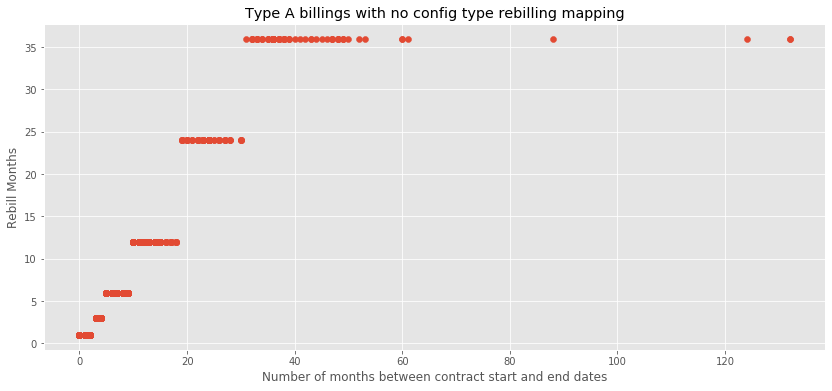

In [56]:
fig, axs = plt.subplots(1,1, figsize=(14,6))
axs.scatter(df_A['months'], df_A['rebill_months'])
axs.set_ylabel('Rebill Months')
axs.set_xlabel('Number of months between contract start and end dates')
axs.set_title('Type A billings with no config type rebilling mapping')
print_text = 'No'

In [57]:
#df_A.head(10)
#df_A.sample(10)
#df_A.tail(10)

###### Dropping the columns we no longer need

In [58]:
df_A.drop(columns = ['start_date', 'end_date', 'month_interval', 'months'], axis=1, inplace=True)

###### Grouping the dataframe by rebill_months using a pivot table

In [59]:
#medals = df.pivot_table('no of medals', ['Year', 'Country'], 'medal')
temp_DC = df_A.pivot_table('DC_amount', ['curr', 'BU', 'period'], 'rebill_months')
temp_US = df_A.pivot_table('US_amount', ['curr', 'BU', 'period'], 'rebill_months')

###### Filling in any zeros that arise if there is no contract on a specific period, currency and BU for a particular rebill period

In [60]:
temp_DC = temp_DC.fillna(0)
temp_US = temp_DC.fillna(0)

###### Flattening the pivot table back to a normal dataframe and renaming the columns

In [61]:
temp_flat_DC = pd.DataFrame(temp_DC.to_records())
temp_flat_US = pd.DataFrame(temp_US.to_records())

In [62]:
temp_flat_DC.rename(index=str, columns={'1.0':'deferred_1M_DC', 
                               '3.0':'deferred_3M_DC',
                               '6.0':'deferred_6M_DC',
                               '12.0':'deferred_1Y_DC',
                               '24.0':'deferred_2Y_DC',
                               '36.0': 'deferred_3Y_DC'}, inplace=True)

temp_flat_US.rename(index=str, columns={'1.0':'deferred_1M_US', 
                               '3.0':'deferred_3M_US',
                               '6.0':'deferred_6M_US',
                               '12.0':'deferred_1Y_US',
                               '24.0':'deferred_2Y_US',
                               '36.0': 'deferred_3Y_US'}, inplace=True)

In [63]:
#temp_flat_DC.head(20)
#temp_flat_US.sample(20)
#temp_flat_DC.tail(20)

###### Quick check that we have not created duplicate column entries (for example two entries for a period with same BU and currency)

In [64]:
df_test_dup = df.copy()
orig_len = len(df_test_dup)
print("Original Length of the dataframe before duplicate test: ", orig_len)

df_test_dup =df_test_dup.drop_duplicates(subset=['curr', 'BU', 'period'])
print('New length of database after duplicates have been removed: ',len(df_test_dup))

if orig_len!=len(df_test_dup):
    print('We had duplicates in the dataframe! Look into why')

Original Length of the dataframe before duplicate test:  4148
New length of database after duplicates have been removed:  4148


###### Merging the billings dataframe with the temp_flat_DC dataframe and and temp_flat_US dataframe and filling in any blanks with zero

In [65]:
df_with_A = pd.merge(df, temp_flat_DC, how='outer',
                    left_on= ['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'], indicator=True, validate='one_to_one')

df_with_A = df_with_A.fillna(pd.Series(0, index=df_with_A.select_dtypes(exclude='category').columns))

In [66]:
df_with_all = pd.merge(df_with_A, temp_flat_US, how='outer',
                    left_on= ['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'])

df_with_all = df_with_all.fillna(pd.Series(0, index=df_with_all.select_dtypes(exclude='category').columns))

In [67]:
#df_with_all.head(10)
#df_with_all.sample(10)
#df_with_all.tail(10)

###### Combining columns form the different data sources (they get merged with different names) and cleaning up the columns

In [68]:
df_with_all['deferred_1M_DC']= df_with_all['deferred_1M_DC_x']+df_with_all['deferred_1M_DC_y']
df_with_all['deferred_3M_DC']= df_with_all['deferred_3M_DC_x']+df_with_all['deferred_3M_DC_y']
df_with_all['deferred_6M_DC']= df_with_all['deferred_6M_DC_x']+df_with_all['deferred_6M_DC_y']
df_with_all['deferred_1Y_DC']= df_with_all['deferred_1Y_DC_x']+df_with_all['deferred_1Y_DC_y']
df_with_all['deferred_2Y_DC']= df_with_all['deferred_2Y_DC_x']+df_with_all['deferred_2Y_DC_y']
df_with_all['deferred_3Y_DC']= df_with_all['deferred_3Y_DC_x']+df_with_all['deferred_3Y_DC_y']

df_with_all['deferred_1M_US']= df_with_all['deferred_1M_US_x']+df_with_all['deferred_1M_US_y']
df_with_all['deferred_3M_US']= df_with_all['deferred_3M_US_x']+df_with_all['deferred_3M_US_y']
df_with_all['deferred_6M_US']= df_with_all['deferred_6M_US_x']+df_with_all['deferred_6M_US_y']
df_with_all['deferred_1Y_US']= df_with_all['deferred_1Y_US_x']+df_with_all['deferred_1Y_US_y']
df_with_all['deferred_2Y_US']= df_with_all['deferred_2Y_US_x']+df_with_all['deferred_2Y_US_y']
df_with_all['deferred_3Y_US']= df_with_all['deferred_3Y_US_x']+df_with_all['deferred_3Y_US_y']

df_with_all.drop(labels = ['deferred_1M_DC_x','deferred_1M_DC_y',
                        'deferred_3M_DC_x','deferred_3M_DC_y',
                        'deferred_6M_DC_x','deferred_6M_DC_y',
                        'deferred_1Y_DC_x','deferred_1Y_DC_y',
                        'deferred_2Y_DC_x','deferred_2Y_DC_y',
                        'deferred_3Y_DC_x','deferred_3Y_DC_y',
                        'deferred_1M_US_x','deferred_1M_US_y',   
                        'deferred_3M_US_x','deferred_3M_US_y',
                        'deferred_6M_US_x','deferred_6M_US_y',
                        'deferred_1Y_US_x','deferred_1Y_US_y',
                        'deferred_2Y_US_x','deferred_2Y_US_y',
                        'deferred_3Y_US_x','deferred_3Y_US_y'],
                         axis=1, inplace=True)

In [69]:
#df_with_all.head(5)
#df_with_all.sample(5)
#df_with_all.tail(5)

###### Checking totals to se if they match what we expect

In [70]:
print('sum of temp flat DC 1M:      ', temp_flat_DC['deferred_1M_DC'].sum())
print('sum of base_df before DC 1M: ', df['deferred_1M_DC'].sum())
print('sum of final DC 1M:          ', df_with_all['deferred_1M_DC'].sum())

a = temp_flat_DC['deferred_1M_DC'].sum()
b = df['deferred_1M_DC'].sum()
c = df_with_all['deferred_1M_DC'].sum()
print(c)
print(a+b)

sum of temp flat DC 1M:       355116274.5532136
sum of base_df before DC 1M:  161227626386.43
sum of final DC 1M:           161582742660.98322
161582742660.98322
161582742660.98322


# TO BE DONE: Create a table that contains the total billings by DC for each dataframe and each step for auditing

 - start with all of the DC
 - then create function that appends and adds rows
 - then do the same for the DC stuff type_A
 - then check the totals


##### Renaming the cleaned billings dataframe as df_billings

In [71]:
df_billings = df_with_all.copy()

###### Checking that there are no bilings from future periods in this dataframe. If so, drop them

In [72]:
drop_index= df_billings[df_billings['period']=='2020-04'].index
df_billings.drop(drop_index, inplace=True)

##### Sorting the dataframe and saving this dataframe for use later in a pickle file

In [73]:
df_billings = df_billings.sort_values(['curr', 'BU', 'period'], ascending = (True, True, True))

with open('../data/processed/all_billings.p', 'wb') as f:
    pickle.dump(df_billings, f)  

### Loading All of the other information we need here from excel files
 - currency_map: contain a mapping of currency the majority of our billings in each country
 - FX_data: contains current spot rates, FX forward rates and FX volatilities
 - FX_forward_rates: contains the forward rates used in the FP&A Plan
 - Bookings Forecast: contains the most recent FP&A net new booking forecast (usually only one fiscal year included)

###### Currency Map

In [74]:
df_curr_map = pd.read_excel("../data/currency_map.xlsx", sheet_name="curr_map")
df_curr_map["Country"] = df_curr_map["Country"].str.replace("\(MA\)", "", case=False)

##### FX data

In [75]:
df_FX_rates = pd.read_excel('../data/FX_data.xlsx', sheet_name='to_matlab')
df_FX_rates['VOL_3M'] = df_FX_rates['VOL_3M']/100
df_FX_rates['VOL_6M'] = df_FX_rates['VOL_6M']/100
df_FX_rates['VOL_9M'] = df_FX_rates['VOL_9M']/100
df_FX_rates['VOL_1Y'] = df_FX_rates['VOL_1Y']/100

In [76]:
#df_FX_rates.head(5)
#df_FX_rates.sample(5)
#df_FX_rates.tail(5)

###### FX Forward Rates used in the FP&A Plan

In [77]:
df_FX_fwds = pd.read_excel('../data/FX_forward_rates.xlsx', sheet_name='forward_data', 
                          skiprows = 1, usecols="C,G")

df_FX_fwds.rename(index=str, columns={'Unnamed: 2': 'curr', 'FWD REF':'forward'}, inplace=True)

In [78]:
# Remove the # below to see the entire list of FX_fwds in the plan
#df_FX_fwds

##### Bookings Forecast

In [79]:
df_bookings = pd.read_excel('../data/2020_bookings_fcst_Q1.xlsx', sheet_name='bookings')

In [80]:
#df_bookings.head(10)
#df_bookings.sample(10)
#df_bookings.tail(10)

### Cleaning up the bookings data
 - remove odd strings such as '(EB)' from BU, (IS) from Internal Segment, etc
 - dropping columns we do not need
 - renaming columns to better match our data naming convention
 
 NOTE: The '('  and ')' is a special character so we need to precede these with the escape character '\'

In [81]:
df_bookings['EBU'] = df_bookings['EBU'].str.replace(' \(EB\)', '', case=False)
df_bookings['Internal Segment'] = df_bookings['Internal Segment'].str.replace('\(IS\)', '')
df_bookings['PMBU'] = df_bookings['PMBU'].str.replace('\(PMBU\)', '')
df_bookings['GEO'] = df_bookings['GEO'].str.replace('\(G\)', '')
df_bookings['Market Area'] = df_bookings['Market Area'].str.replace('\(MA\)', '')

In [82]:
df_bookings.drop(columns = ['Hedge', 'Mark Segment', 'Type', 'Scenario', 'FX'], inplace = True)

df_bookings.rename(index=str, columns = {'EBU': 'BU', 
                                        'Internal Segment': 'segment',
                                        'PMBU': 'product',
                                        'GEO':'geo',
                                        'Market Area': 'country',
                                        'Bookings Type': 'booking_type',
                                        'value': 'US_amount'}, inplace =True)

In [83]:
#df_bookings.head(10)
#df_bookings.sample(10)
#df_bookings.tail(10)

###### The cell below shows samples of what is in the data. Removing one of the parenthesis will execute the code. (One at a time)

In [84]:
#df_bookings['BU'].value_counts()
#df_bookings['segment'].value_counts()
#df_bookings['product'].value_counts()
#df_bookings['country'].value_counts()
#df_bookings['booking_type'].value_counts()

##### Merging the bookings country data to a currency using the currency map dataframe (df_curr_map)

In [85]:
df_curr_map

,Country,Currency
0,Aus and New Zealand,AUD
1,Benelux,EUR
2,Brazil,USD
3,Canada,USD
4,China,USD
5,Eastern Europe,EUR
6,France,EUR
7,Germany,EUR
8,Hong Kong & Taiwan,USD
9,Iberica,EUR


In [86]:
list_book_ctry = df_bookings['country'].unique()
print('Countries in the bookings file: \n', list_book_ctry)

list_curr_map = df_curr_map['Country'].unique()
print('Countries in the currency map file: \n', list_curr_map)


Countries in the bookings file: 
 ['Aus and New Zealand ' 'Benelux ' 'Brazil ' 'Canada ' 'China '
 'Eastern Europe ' 'France ' 'Germany ' 'Hong Kong & Taiwan ' 'Iberica '
 'India ' 'Italy ' 'Japan ' 'Korea ' 'Mediterranean ' 'Mexico '
 'Middle East ' 'Nordic ' 'Russia & CIS ' 'Southeast Asia '
 'SSA & Israel ' 'Strat. Latin America ' 'Switzerland ' 'United Kingdom '
 'United States ']
Countries in the currency map file: 
 ['Aus and New Zealand ' 'Benelux ' 'Brazil ' 'Canada ' 'China '
 'Eastern Europe ' 'France ' 'Germany ' 'Hong Kong & Taiwan ' 'Iberica '
 'India ' 'Italy ' 'Japan ' 'Korea ' 'Mediterranean ' 'Mexico '
 'Middle East ' 'Nordic ' 'Russia & CIS ' 'Southeast Asia '
 'SSA & Israel ' 'Strat. Latin America ' 'Switzerland ' 'Taiwan '
 'United Kingdom ' 'United States ']


##### Checking that we have the currency mapping for every country where we have a bookings forecast

In [87]:
a = list(set(list_book_ctry) & set(list_curr_map))

not_in_map = set(list_book_ctry).difference(set(list_curr_map))
if len(not_in_map)!=0:
    print('There is a bookings currency that is not in the currency map!\nWe need to look into the currency map file and add this!')
else:
    print('The bookings currencies are in the currency map. OK to merge the dataframes.')

The bookings currencies are in the currency map. OK to merge the dataframes.


###### Merge the bookings forecast with the currency map

In [88]:
df_bookings = pd.merge(df_bookings, df_curr_map, how='left', left_on='country', right_on='Country')

In [89]:
#df_bookings.head(10)
#df_bookings.sample(10)
#df_bookings.tail(10)

### Adding periods weeks (from the Adobe calendar) to the billings dataframe

In [90]:
#df_cal.head(10)
#df_cal.sample(10)
#df_cal.tail(10)

##### Creating a column in df_cal with year  '-' the last two digits of the per_ticker to match with the billings dataframe

In [91]:
df_cal['p2digit']=df_cal['Period'].astype(str)
df_cal['p2digit']=df_cal['p2digit'].str.zfill(2)

df_cal['period_match']=df_cal['Year'].astype(str) + '-' + df_cal['p2digit'].astype(str)

df_cal.drop(['p2digit'],axis=1, inplace=True)

In [92]:
#df_cal.head(10)
#df_cal.sample(10)
#df_cal.tail(10)

##### Getting the calendar ready to be merged with the df_billings dataframe by removing columns that are not needed

In [93]:
df_cal_2_merge = df_cal.copy()
df_cal_2_merge.drop(['Year', 'Quarter', 'Period', 'Qtr_Ticker', 'Qtr_Start', 'Qtr_End', 'Per_Start',
                     'Per_Ticker','Per_End'], axis=1, inplace=True)

##### Merging the calendar periods with the periods in the df_billings dataframe to bring over period weeks

In [94]:
df_billings = df_billings.merge(df_cal_2_merge, how='left', left_on='period', right_on='period_match')
df_billings.drop(['period_match', '_merge'], axis=1, inplace=True)

In [95]:
df_billings.columns

Index(['curr', 'BU', 'period', 'recognized_DC', 'recognized_US', 'service_DC',
       'service_US', 'deferred_B_DC', 'deferred_B_US', 'deferred_1M_DC',
       'deferred_3M_DC', 'deferred_6M_DC', 'deferred_1Y_DC', 'deferred_2Y_DC',
       'deferred_3Y_DC', 'deferred_1M_US', 'deferred_3M_US', 'deferred_6M_US',
       'deferred_1Y_US', 'deferred_2Y_US', 'deferred_3Y_US', 'Period_Weeks'],
      dtype='object')

In [96]:
#df_billings.head(5)
#df_billings.sample(5)
#df_billings.tail(5)

##### Saving these dataframes in as a python dictionary in the pickle file 'all_inputs.p'

In [97]:
df_billings=df_billings.sort_values(['curr', 'BU', 'period'], ascending = (True, True, True))

input_df_dict = {'model_dict': model_dict,
                 'billings':df_billings, 
                 'ADBE_cal':df_cal,
                 'bookings': df_bookings,
                 'FX_forwards': df_FX_fwds,
                 'FX_rates': df_FX_rates
                }

pickle.dump(input_df_dict, open('../data/processed/all_inputs.p', 'wb'))

### Cleaning up the billings dataframe
- the billings dataframe does not contain every period if there are no bookings within a period.
- the easiest way to create the forecast requires that we have all of the periods in each BU and currency pair (or at least 36 months worth so that we can incorporate the 3 year deferred bookings

###### The bookings foreacast also contains products such as 'LiveCycle' and 'other solutions' that we do not expect to recieve billings for going forward (there are no booking associated with this) so we need to remove them from the billings data

In [98]:
def add_billings_periods(df_billings):
    # clean up billings by removing LiveCycle and other solutions
    index_lc = df_billings[df_billings['BU']=='LiveCycle'].index
    df_billings.drop(index_lc, inplace=True)

    index_other = df_billings[df_billings['BU']=='Other Solutions'].index
    df_billings.drop(index_other, inplace=True)

    
    all_BU = df_billings['BU'].unique()
    all_curr = df_billings['curr'].unique()

    all_periods = df_billings['period'].unique()
    all_periods = np.sort(all_periods)
    all_periods = all_periods[-36:]


    list_new_BUs = []
    list_new_currs = []
    list_new_periods = []

    for this_BU in all_BU:

        for this_curr in all_curr:

            df_slice = df_billings[(df_billings['BU']== this_BU)&
                                   (df_billings['curr']==this_curr)].copy()

            list_periods = df_slice['period'].unique()
            set_periods = set(list_periods)
            set_all = set(all_periods)

            periods_missing = set_all.difference(set_periods)

            for i in periods_missing:
                list_new_periods.append(i)
                list_new_currs.append(this_curr)
                list_new_BUs.append(this_BU)


    df_to_add = pd.DataFrame({'curr': list_new_currs, 
                              'BU': list_new_BUs,
                              'period': list_new_periods})

    df_billings_check = pd.concat([df_billings, df_to_add], sort=False)

    df_billings_check = df_billings_check.fillna(0)

    df_billings = df_billings_check.copy()
    
    df_billings=df_billings.sort_values(['curr', 'BU', 'period'], ascending = (True, True, True))

    return df_billings


###### Explicit call to the add_billings_periods function is below

In [99]:
print('Length of df_billings before removal of old BUs and adding periods:', len(df_billings))
df_billings = add_billings_periods(df_billings)
print('Length of df_billings after removal of old BUs and adding periods:', len(df_billings))

Length of df_billings before removal of old BUs and adding periods: 4091
Length of df_billings after removal of old BUs and adding periods: 6053


## Cleaning up the bookings dataframe to be incorporated into the deferred model
- The billings dataframe is by period
- the bookings dataframe contains net new bookings by quarter


In [100]:
# find the last period in the billings index
last_period = '2020-03'

list_BUs = df_bookings['BU'].unique()
list_curr = df_bookings['Currency'].unique()

print('This is the list of BUs in the bookings dataframe: ', list_BUs)
print('This is the list of currencies in the bookings dataframe: ', list_curr)


This is the list of BUs in the bookings dataframe:  ['Experience Cloud' 'Creative' 'Document Cloud']
This is the list of currencies in the bookings dataframe:  ['AUD' 'EUR' 'USD' 'JPY' 'GBP']


##### Creating data to add to the billings dataframe to incorporate period by period billings 
NOTE:  This is just creating the space in the dataframe for the data. We will fill it in later

In [101]:
# creating dataframe of zeros
l_BU = []
l_curr = []
for BU in list_BUs:
    for curr in list_curr:
        l_BU.append(BU)
        l_curr.append(curr)
#print(l_BU)
#print(l_curr)
l_zero = np.zeros(len(l_BU))

In [102]:
data= {'BU':l_BU, 'curr':l_curr, 
      'Q1':l_zero,
      'Q2':l_zero,
      'Q3':l_zero,
      'Q4':l_zero,
      'P01':l_zero,
      'P02':l_zero,
      'P03':l_zero,
      'P04':l_zero,
      'P05':l_zero,
      'P06':l_zero,
      'P07':l_zero,
       'P08':l_zero,
       'P09':l_zero,
       'P10':l_zero,
       'P11':l_zero,
       'P12':l_zero,
      }

df_book_period=pd.DataFrame(data)

In [103]:
#df_book_period.head(14)

##### Uncomment below to remember what the df_bookings looked like

In [104]:
#df_bookings.head(10)
#df_bookings.sample(10)
#df_bookings.tail(10)

##### The cell below fills in the df_book_period dataframe with the quarterly bookings numbers for each BU and currency

In [105]:
# fill in the quarters
for i in range(len(df_book_period['BU'])):
    
    this_BU = df_book_period['BU'][i]
    this_curr = df_book_period['curr'][i]
    this_slice = df_bookings[(df_bookings['BU']==this_BU)&
                          (df_bookings['Currency']==this_curr)]
    
    this_Q1= this_slice[this_slice['Quarter']=='Q1 2020']
    sum_Q1 = this_Q1['US_amount'].sum()
    df_book_period['Q1'].loc[i]=sum_Q1
    
    this_Q2= this_slice[this_slice['Quarter']=='Q2 2020']
    sum_Q2 = this_Q2['US_amount'].sum()
    df_book_period['Q2'].loc[i]=sum_Q2
    
    this_Q3= this_slice[this_slice['Quarter']=='Q4 2020']
    sum_Q3 = this_Q3['US_amount'].sum()
    df_book_period['Q3'].loc[i]=sum_Q3
    
    this_Q4= this_slice[this_slice['Quarter']=='Q4 2020']
    sum_Q4 = this_Q4['US_amount'].sum()
    df_book_period['Q4'].loc[i]=sum_Q4


/Users/davidsmith/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [106]:
#df_book_period.head(10)
#df_book_period.sample(10)
#df_book_period.tail(10)

##### Creating lists of periods and quarters needed to fill out the df_book_period dataframe

In [107]:
# list of quarters for the percentages
list_q2 = ['2019-04', '2019-05', '2019-06']
list_q3 = ['2019-07', '2019-08', '2019-09']
list_q4 = ['2019-10', '2019-11', '2019-12']
list_q1 = [ '2020-01', '2020-02', '2020-03']

list_periods = ['2020-01', '2020-02', '2020-03',
                '2019-04', '2019-05', '2019-06',
                '2019-07', '2019-08', '2019-09',
                '2019-10', '2019-11', '2019-12']

list_p_headers = ['P01', 'P02', 'P03',
                  'P04', 'P05', 'P06',
                  'P07', 'P08', 'P09',
                  'P10', 'P11', 'P12'
                 ]

list_q_headers = ['Q1', 'Q1', 'Q1',
                  'Q2', 'Q2', 'Q2',
                  'Q3', 'Q3', 'Q3',
                  'Q4', 'Q4', 'Q4']


##### adding the booking periods to the dataframe. The bookings are split into periods based on last years percentage of 1 year deferred billings within the quarter.
For example: P1 = 25%, P2 = 30%, P3 = 45% such that the sum is equal to the total quarterly billings last year

In [108]:
for i in range(len(df_book_period['BU'])):
    
    this_BU = df_book_period['BU'][i]
    this_curr = df_book_period['curr'][i]
    
    this_slice = df_billings[(df_billings['BU']==this_BU)&
                          (df_billings['curr']==this_curr)]
    
    for j in range(len(list_periods)):
        this_period = list_periods[j]
        this_header = list_p_headers[j]
        this_quarter = list_q_headers[j]
        this_P_slice = this_slice[this_slice['period']==this_period]
        df_book_period.loc[[i],[this_header]]=this_P_slice['deferred_1Y_DC'].sum()
        
df_book_period['bill_Q1_sum'] = df_book_period['P01'] + df_book_period['P02'] + df_book_period['P03']    
df_book_period['bill_Q2_sum'] = df_book_period['P04'] + df_book_period['P05'] + df_book_period['P06']    
df_book_period['bill_Q3_sum'] = df_book_period['P07'] + df_book_period['P08'] + df_book_period['P09']    
df_book_period['bill_Q4_sum'] = df_book_period['P10'] + df_book_period['P11'] + df_book_period['P12']    

df_book_period['P01'] = df_book_period['Q1']*df_book_period['P01']/df_book_period['bill_Q1_sum']
df_book_period['P02'] = df_book_period['Q1']*df_book_period['P02']/df_book_period['bill_Q1_sum']
df_book_period['P03'] = df_book_period['Q1']*df_book_period['P03']/df_book_period['bill_Q1_sum']

df_book_period['P04'] = df_book_period['Q2']*df_book_period['P04']/df_book_period['bill_Q2_sum']
df_book_period['P05'] = df_book_period['Q2']*df_book_period['P05']/df_book_period['bill_Q2_sum']
df_book_period['P06'] = df_book_period['Q2']*df_book_period['P06']/df_book_period['bill_Q2_sum']

df_book_period['P07'] = df_book_period['Q3']*df_book_period['P07']/df_book_period['bill_Q3_sum']
df_book_period['P08'] = df_book_period['Q3']*df_book_period['P08']/df_book_period['bill_Q3_sum']
df_book_period['P09'] = df_book_period['Q3']*df_book_period['P09']/df_book_period['bill_Q3_sum']

df_book_period['P10'] = df_book_period['Q4']*df_book_period['P10']/df_book_period['bill_Q4_sum']
df_book_period['P11'] = df_book_period['Q4']*df_book_period['P11']/df_book_period['bill_Q4_sum']
df_book_period['P12'] = df_book_period['Q4']*df_book_period['P12']/df_book_period['bill_Q4_sum']
  

In [109]:
#df_book_period.head(10)
#df_book_period.sample(10)
df_book_period.tail(10)

,BU,curr,Q1,Q2,Q3,Q4,P01,P02,P03,P04,...,P07,P08,P09,P10,P11,P12,bill_Q1_sum,bill_Q2_sum,bill_Q3_sum,bill_Q4_sum
5,Creative,AUD,1.393692e+07,1.379181e+07,2.364523e+07,2.364523e+07,4.502145e+06,3.363263e+06,6.071509e+06,3.892268e+06,...,6.937723e+06,7.857480e+06,8.850029e+06,5.861274e+06,5.146632e+06,1.263733e+07,3.256804e+07,3.351668e+07,3.974319e+07,4.712909e+07
6,Creative,EUR,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.632360e+08,1.348083e+08,1.558901e+08,2.169764e+08
7,Creative,USD,2.075290e+07,1.613099e+07,3.783942e+07,3.783942e+07,7.004166e+06,5.285728e+06,8.463003e+06,4.495379e+06,...,1.041130e+07,9.500524e+06,1.792759e+07,1.064223e+07,1.080927e+07,1.638791e+07,4.939587e+08,4.483563e+08,5.794996e+08,5.868422e+08
8,Creative,JPY,2.711939e+06,6.155972e+06,5.318174e+06,5.318174e+06,7.529930e+05,6.734288e+05,1.285517e+06,1.648482e+06,...,1.427165e+06,1.766215e+06,2.124794e+06,1.646169e+06,1.148706e+06,2.523300e+06,9.671118e+09,1.286305e+10,1.101781e+10,1.018881e+10
9,Creative,GBP,1.579663e+07,1.104858e+07,2.342099e+07,2.342099e+07,5.636788e+06,4.382726e+06,5.777112e+06,3.215084e+06,...,5.618554e+06,5.051653e+06,1.275078e+07,7.468475e+06,5.897097e+06,1.005542e+07,3.179986e+07,2.861961e+07,4.507428e+07,3.930805e+07
10,Document Cloud,AUD,2.705300e+06,2.335687e+06,3.061921e+06,3.061921e+06,9.795144e+05,5.914267e+05,1.134359e+06,5.570840e+05,...,8.918117e+05,1.047172e+06,1.122937e+06,7.815795e+05,6.459415e+05,1.634400e+06,1.107115e+07,1.151846e+07,1.401333e+07,1.877676e+07
11,Document Cloud,EUR,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.723555e+07,2.963811e+07,3.219298e+07,5.370314e+07
12,Document Cloud,USD,1.282261e+07,1.218840e+07,2.995207e+07,2.995207e+07,4.087741e+06,3.065067e+06,5.669800e+06,3.158858e+06,...,1.029812e+07,6.634950e+06,1.301900e+07,7.138428e+06,8.895593e+06,1.391805e+07,1.646339e+08,1.376706e+08,1.669666e+08,2.211843e+08
13,Document Cloud,JPY,5.782041e+05,9.107898e+05,1.260247e+06,1.260247e+06,1.236745e+05,9.184171e+04,3.626880e+05,2.326397e+05,...,3.983124e+05,3.201474e+05,5.417874e+05,2.739214e+05,3.627093e+05,6.236165e+05,1.110632e+09,7.732168e+08,7.701143e+08,1.107132e+09
14,Document Cloud,GBP,7.157459e+06,7.359043e+06,1.397187e+07,1.397187e+07,3.149514e+06,1.643228e+06,2.364717e+06,1.632347e+06,...,5.830285e+06,3.205887e+06,4.935697e+06,4.037839e+06,3.867615e+06,6.066415e+06,1.605065e+07,1.243706e+07,1.174945e+07,1.123952e+07


###### Cleaning up the dataframe by dropping the columns we no longer need

In [110]:
df_book_period.drop(['bill_Q1_sum', 'bill_Q2_sum', 'bill_Q3_sum', 'bill_Q4_sum'], axis=1,inplace=True)

##### Converting these billings to local currency based on the forward rates at the time the plan was created

In [111]:
df_FX_fwds.set_index('curr', inplace=True)

list_fwds =[]
for i in range(len(df_book_period['curr'])):
    this_curr = df_book_period['curr'][i]
    
    if this_curr == 'USD':
        this_fwd=1
    else:
        this_fwd = df_FX_fwds.loc[this_curr, 'forward']
    
    
    list_fwds.append(this_fwd)
df_book_period['FX_fwd_rate'] = list_fwds

df_book_period['P01_DC']=df_book_period['P01']* df_book_period['FX_fwd_rate']
df_book_period['P02_DC']=df_book_period['P02']* df_book_period['FX_fwd_rate']
df_book_period['P03_DC']=df_book_period['P03']* df_book_period['FX_fwd_rate']
df_book_period['P04_DC']=df_book_period['P04']* df_book_period['FX_fwd_rate']
df_book_period['P05_DC']=df_book_period['P05']* df_book_period['FX_fwd_rate']
df_book_period['P06_DC']=df_book_period['P06']* df_book_period['FX_fwd_rate']
df_book_period['P07_DC']=df_book_period['P07']* df_book_period['FX_fwd_rate']
df_book_period['P08_DC']=df_book_period['P08']* df_book_period['FX_fwd_rate']
df_book_period['P09_DC']=df_book_period['P09']* df_book_period['FX_fwd_rate']
df_book_period['P10_DC']=df_book_period['P10']* df_book_period['FX_fwd_rate']
df_book_period['P11_DC']=df_book_period['P11']* df_book_period['FX_fwd_rate']
df_book_period['P12_DC']=df_book_period['P12']* df_book_period['FX_fwd_rate']

In [112]:
#df_book_period.head(10)
#df_book_period.sample(10)
df_book_period.tail(10)

,BU,curr,Q1,Q2,Q3,Q4,P01,P02,P03,P04,...,P03_DC,P04_DC,P05_DC,P06_DC,P07_DC,P08_DC,P09_DC,P10_DC,P11_DC,P12_DC
5,Creative,AUD,1.393692e+07,1.379181e+07,2.364523e+07,2.364523e+07,4.502145e+06,3.363263e+06,6.071509e+06,3.892268e+06,...,9.053531e+06,5.803955e+06,5.146595e+06,9.615103e+06,1.034519e+07,1.171668e+07,1.319672e+07,8.740039e+06,7.674401e+06,1.884415e+07
6,Creative,EUR,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,Creative,USD,2.075290e+07,1.613099e+07,3.783942e+07,3.783942e+07,7.004166e+06,5.285728e+06,8.463003e+06,4.495379e+06,...,8.463003e+06,4.495379e+06,4.273529e+06,7.362081e+06,1.041130e+07,9.500524e+06,1.792759e+07,1.064223e+07,1.080927e+07,1.638791e+07
8,Creative,JPY,2.711939e+06,6.155972e+06,5.318174e+06,5.318174e+06,7.529930e+05,6.734288e+05,1.285517e+06,1.648482e+06,...,1.400805e+08,1.796321e+08,2.404396e+08,2.507335e+08,1.555156e+08,1.924612e+08,2.315350e+08,1.793800e+08,1.251724e+08,2.749595e+08
9,Creative,GBP,1.579663e+07,1.104858e+07,2.342099e+07,2.342099e+07,5.636788e+06,4.382726e+06,5.777112e+06,3.215084e+06,...,4.427168e+06,2.463812e+06,2.359627e+06,3.643405e+06,4.305661e+06,3.871228e+06,9.771293e+06,5.723309e+06,4.519116e+06,7.705757e+06
10,Document Cloud,AUD,2.705300e+06,2.335687e+06,3.061921e+06,3.061921e+06,9.795144e+05,5.914267e+05,1.134359e+06,5.570840e+05,...,1.691499e+06,8.306958e+05,9.039296e+05,1.748234e+06,1.329825e+06,1.561491e+06,1.674468e+06,1.165452e+06,9.631956e+05,2.437136e+06
11,Document Cloud,EUR,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
12,Document Cloud,USD,1.282261e+07,1.218840e+07,2.995207e+07,2.995207e+07,4.087741e+06,3.065067e+06,5.669800e+06,3.158858e+06,...,5.669800e+06,3.158858e+06,2.980298e+06,6.049245e+06,1.029812e+07,6.634950e+06,1.301900e+07,7.138428e+06,8.895593e+06,1.391805e+07
13,Document Cloud,JPY,5.782041e+05,9.107898e+05,1.260247e+06,1.260247e+06,1.236745e+05,9.184171e+04,3.626880e+05,2.326397e+05,...,3.952146e+07,2.535033e+07,2.147187e+07,5.242492e+07,4.340339e+07,3.488588e+07,5.903760e+07,2.984872e+07,3.952378e+07,6.795437e+07
14,Document Cloud,GBP,7.157459e+06,7.359043e+06,1.397187e+07,1.397187e+07,3.149514e+06,1.643228e+06,2.364717e+06,1.632347e+06,...,1.812151e+06,1.250915e+06,8.479540e+05,3.540579e+06,4.467916e+06,2.456764e+06,3.782368e+06,3.094313e+06,2.963866e+06,4.648870e+06


##### The df_book_period dataframe now has columns for bookings each period in both local currency and document currency

In [113]:
df_book_period.columns

Index(['BU', 'curr', 'Q1', 'Q2', 'Q3', 'Q4', 'P01', 'P02', 'P03', 'P04', 'P05',
       'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12', 'FX_fwd_rate',
       'P01_DC', 'P02_DC', 'P03_DC', 'P04_DC', 'P05_DC', 'P06_DC', 'P07_DC',
       'P08_DC', 'P09_DC', 'P10_DC', 'P11_DC', 'P12_DC'],
      dtype='object')

## Building the billings forecast in a dataframe called df_fcst

###  Forecasting the billings into the future
#### Steps
 - create list of bill periods that is sorted for the lookup functions
 - create forecast dataframe that includes the same columns (though in document currency) for the billings
 - add the bookings forecast to this data
 - create impact on deferred (project the new waterfall from this_
 - load up accounting's version of the initial waterfall (by BU)
 - reporting

###### creating the list of historical bill periods

In [114]:
list_bill_periods = df_billings['period'].unique()
list_bill_periods.sort()
print(list_bill_periods)

['2015-01' '2015-02' '2015-03' '2015-04' '2015-05' '2015-06' '2015-07'
 '2015-08' '2015-09' '2015-10' '2015-11' '2015-12' '2016-01' '2016-02'
 '2016-03' '2016-04' '2016-05' '2016-06' '2016-07' '2016-08' '2016-09'
 '2016-10' '2016-11' '2016-12' '2017-01' '2017-02' '2017-03' '2017-04'
 '2017-05' '2017-06' '2017-07' '2017-08' '2017-09' '2017-10' '2017-11'
 '2017-12' '2018-01' '2018-02' '2018-03' '2018-04' '2018-05' '2018-06'
 '2018-07' '2018-08' '2018-09' '2018-10' '2018-11' '2018-12' '2019-01'
 '2019-02' '2019-03' '2019-04' '2019-05' '2019-06' '2019-07' '2019-08'
 '2019-09' '2019-10' '2019-11' '2019-12' '2020-01' '2020-02' '2020-03']


In [115]:
v_BU = df_billings['BU'].copy()
v_curr = df_billings['curr'].copy()
v_both = v_BU + v_curr
v_unique = v_both.unique()

v_un_BU = [sub[:-3] for sub in v_unique]
v_un_curr = [sub[-3:] for sub in v_unique]


In [116]:
list_future_periods = ['2020-04', '2020-05', '2020-06',
                       '2020-07', '2020-08', '2020-09',
                       '2020-10', '2020-11', '2020-12',
                       '2021-01', '2021-02', '2021-03']

In [117]:
# creating the vectors for the future billings dataframe
v_BU_2_df=[]
v_curr_2_df=[]
v_period_2_df = []

for i in range(len(v_un_BU)):
    this_BU = v_un_BU[i]
    this_curr = v_un_curr[i]
    
    for period in list_future_periods:
        v_BU_2_df.append(this_BU)
        v_curr_2_df.append(this_curr)
        v_period_2_df.append(period)

print('This is the length of the vectors: ',len(v_BU_2_df))
    

This is the length of the vectors:  1620


##### Creating a list of the columns that we need to use in the df_billings dataframe (They contain document currency billings)

In [118]:
list_all_columns = df_billings.columns

list_keepers= []
for i in list_all_columns:
    
    if i[-2:]=='DC':
        list_keepers.append(i)

list_keepers

['recognized_DC',
 'service_DC',
 'deferred_B_DC',
 'deferred_1M_DC',
 'deferred_3M_DC',
 'deferred_6M_DC',
 'deferred_1Y_DC',
 'deferred_2Y_DC',
 'deferred_3Y_DC']

##### Creating the df_fcst dataframe with every currency, BU and period we need

In [119]:
df_fcst = pd.DataFrame({'curr': v_curr_2_df,
                        'BU': v_BU_2_df,
                       'period': v_period_2_df})

###### Adding the columns we need to populate (list_keepers)

In [120]:
for col in list_keepers:
    df_fcst[col]=0

In [121]:
#df_fcst.head(10)
#df_fcst.sample(10)
#df_fcst.head(10)

##### Adding period weeks to the forecast

In [122]:
df_cal_2_merge = df_cal.copy()
df_cal_2_merge.drop(['Year', 'Quarter', 'Period', 'Qtr_Ticker', 'Qtr_Start', 'Qtr_End', 'Per_Start',
                     'Per_Ticker','Per_End'], axis=1, inplace=True)

df_fcst = df_fcst.merge(df_cal_2_merge, how='left', left_on='period', right_on='period_match')
df_fcst.drop(['period_match'], axis=1, inplace=True)


In [123]:
#df_fcst.head(10)
#df_fcst.sample(10)
#df_fcst.tail(10)

### The functions below create the billings forecast by looking up the historical billings and having them renew
NOTE: The monthly billings are using a linear regression model on the monthly billings / weeks in the month

### TO BE DONE TO COMPLETE:
 - the monthly billings contain several BU, currency pairs that have no monthly billings history. We need to shortcut the program by adding an if statement in that case
 - we need to alter the monthly program to search the periods for the best time period to use (maximizing the R-squared) since some of the BU, currency pairs exhibit growth only after a few years
 - determine which print statement need to be kept to make sure it is running appropriately
 - remove slice error warnings after investigating where the problem occurs

In [124]:
def find_unique_curr_and_BU(df_billings):
    v_BU = df_billings['BU'].copy()
    v_curr = df_billings['curr'].copy()
    v_both = v_BU + v_curr
    v_unique = v_both.unique()

    v_un_BU = [sub[:-3] for sub in v_unique]
    v_un_curr = [sub[-3:] for sub in v_unique]

    return v_un_BU, v_un_curr

In [125]:
def create_billing_forecast(df_billings, df_fcst):

    v_un_BU, v_un_curr = find_unique_curr_and_BU(df_billings)
    
    # new Vectorized approach (sort of)
    counter = 0

    for i in range(len(v_un_BU)):
        this_BU = v_un_BU[i]
        this_curr = v_un_curr[i]
        
        print('working on BU: {0}  and currency: {1}'.format(this_BU, this_curr))
        df_slice = df_billings[(df_billings['BU']==this_BU) &
                                (df_billings['curr']== this_curr)].copy()


        old_per_3Y = list_bill_periods[-36:-24]
        old_per_2Y = list_bill_periods[-24:-12]
        old_per_1Y = list_bill_periods[-12:]
        old_per_6M = list_bill_periods[-6:]
        old_per_3M = list_bill_periods[-3:]

        # three year
        this_v_3yrs = df_slice.loc[df_slice['period'].isin(old_per_3Y), 'deferred_3Y_DC'].copy()
        if len(this_v_3yrs)!=12:
            print(this_BU, this_curr)
            print("There is a period mismatch. length of 3yrs vector = ", len(this_v_3yrs))
            print('Length of df_slice: ', len(df_slice))    
            print('This BU: {0} and this currency: {1}'.format(this_BU, this_curr))

        else:        
            df_fcst.loc[(df_fcst['BU']==this_BU)&
                            (df_fcst['curr']==this_curr),
                            'deferred_3Y_DC'] = this_v_3yrs.values

        #two years
        this_v_2yrs = df_slice.loc[df_slice['period'].isin(old_per_2Y), 'deferred_2Y_DC'].copy()
        if len(this_v_2yrs)!=12:
            print(this_BU, this_curr)
            print("There is a period mismatch. length of 2 yrs vector = ", len(this_v_2yrs))
            print('Length of df_slice: ', len(df_slice))    
            print('This BU: {0} and this currency: {1}'.format(this_BU, this_curr))
        else:
            df_fcst.loc[(df_fcst['BU']==this_BU)&
                        (df_fcst['curr']==this_curr),
                        'deferred_2Y_DC'] = this_v_2yrs.values

        # one year
        this_v_1yrs = df_slice.loc[df_slice['period'].isin(old_per_1Y), 'deferred_1Y_DC'].copy()
        if len(this_v_1yrs)!= 12:
            print(this_BU, this_curr)
            print("There is a period mismatch. length of 1 yr vector = ", len(this_v_1yrs))
            print('Length of df_slice: ', len(df_slice))    

        else:
            df_fcst.loc[(df_fcst['BU']==this_BU)&
                        (df_fcst['curr']==this_curr),
                        'deferred_1Y_DC'] = this_v_1yrs.values

        # six months (we need to append the values to repeat once)
        this_v_6M = df_slice.loc[df_slice['period'].isin(old_per_6M), 'deferred_6M_DC'].copy()
        this_v_6M = this_v_6M.append(this_v_6M, ignore_index=True)

        df_fcst.loc[(df_fcst['BU']==this_BU)&
                    (df_fcst['curr']==this_curr),
                    'deferred_6M_DC'] = this_v_6M.values

        # three months:
        this_v_3M = df_slice.loc[df_slice['period'].isin(old_per_3M), 'deferred_3M_DC'].copy()
        this_v_3M = this_v_3M.append(this_v_3M, ignore_index=True)
        this_v_3M = this_v_3M.append(this_v_3M, ignore_index=True)

        df_fcst.loc[(df_fcst['BU']==this_BU)&
                    (df_fcst['curr']==this_curr),
                    'deferred_3M_DC'] = this_v_3M.values

        # what the hell do we do with the service and recognized revenue billings?
        # RECOGNIZED REVENUE - does not go to deferred, so just take the last 12 month's worth
        this_recog = df_slice.loc[df_slice['period'].isin(old_per_1Y), 'recognized_DC'].copy()
        df_fcst.loc[(df_fcst['BU']==this_BU) &
                    (df_fcst['curr']==this_curr),
                   'recognized_DC'] = this_recog.values

        # SERVICE BASED BILLINGS - for now just use the average of whatever we used last time
        this_svc = df_slice.loc[df_slice['period'].isin(old_per_1Y), 'service_DC'].copy()
        df_fcst.loc[(df_fcst['BU']==this_BU) &
                    (df_fcst['curr']==this_curr),
                   'service_DC'] = this_svc.values

        # Type B Deferred (Service Billings)
        this_type_B = df_slice.loc[df_slice['period'].isin(old_per_1Y), 'deferred_B_DC'].copy()
        df_fcst.loc[(df_fcst['BU']==this_BU) &
                    (df_fcst['curr']==this_curr),
                   'deferred_B_DC'] = this_type_B.values
        
        # MONTHLY BILLINGS
        # here we need to call a seperate function using just the X array that is the one month billings
        this_y= df_slice['deferred_1M_DC'].copy()
        this_y = this_y.to_numpy()
        this_y = this_y.reshape(-1,1)
        
        
        if sum(this_y)!=0:
        
            period_weeks = df_slice['Period_Weeks'].copy()
            period_weeks = period_weeks.to_numpy()
            period_weeks = period_weeks.reshape(-1,1)

            this_y = np.true_divide(this_y, period_weeks)
            this_y = np.nan_to_num(this_y)
            X = np.arange(len(this_y))

            this_model  = build_monthly_forecast(X, this_y)
            weekly_fcst_y = this_model['fcst_y'] 
            
            fcst_slice = df_fcst[(df_fcst['BU']==this_BU)&
                                 (df_fcst['curr']==this_curr)].copy()
            fcst_weeks = fcst_slice['Period_Weeks'].to_numpy()
            fcst_weeks=fcst_weeks.reshape(-1,1)

            period_fcst_y = weekly_fcst_y * fcst_weeks
            
            #print('length of new_y: ', len(fcst_y))
            df_fcst.loc[(df_fcst['BU']==this_BU) &
                        (df_fcst['curr']==this_curr),
                        'deferred_1M_DC'] = period_fcst_y

            df_fcst.loc[(df_fcst['BU']==this_BU)&
                       (df_fcst['curr']==this_curr),
                        'r_squared']= this_model['score']

            df_fcst.loc[(df_fcst['BU']==this_BU)&
                       (df_fcst['curr']==this_curr),
                        'intercept']= this_model['intercept']

            df_fcst.loc[(df_fcst['BU']==this_BU)&
                       (df_fcst['curr']==this_curr),
                        'coeff']= this_model['coeff']

            df_fcst.loc[(df_fcst['BU']==this_BU)&
                   (df_fcst['curr']==this_curr),
                    'X_length']= this_model['first_row']
        
        #print('For this BU: {0} and this currency {1}, we have a score of {2}, and int of {3} and a coeff of {4}'.
        #     format(this_BU, this_curr, this_score, this_int, this_coeff))
        #NOTE: We will need to return two things here
        # First - the df_fcst dataframe
        # second - a dictionary describing the monthly forecasts
    
    
    return df_fcst
    

In [126]:
def build_monthly_forecast(X, y):
    '''
    Need to keep track of the initial X and Y
    Need to track the best X, best Y, best model & best score
    Within the loop, reducing the X and Y to new_x and new_y and keeping track of new model
    If the new model is better, the best_x, best_y, best_model and best_score are overwritten
    
    At the end of the program, the best model is fit and the relevant information is returned
    '''
    
    X = X.reshape(-1,1)
    y = y.reshape(-1,1)
    
    best_X = X.reshape(-1,1)
    best_y = y.reshape(-1,1)
    
    fcst_X = np.arange(np.max(X)+1, np.max(X)+13)
    fcst_X = fcst_X.reshape(-1,1)
    
    # best row tracks the beginning month used for the model
    best_row = 0
    
    # create initial linear regression model, fit it and record score
    best_model = LinearRegression(fit_intercept=True)
    best_model.fit(best_X, best_y)
    best_score = best_model.score(best_X, best_y)
    best_int =   best_model.intercept_
    best_coeff = best_model.coef_

    #print("Model Score :",       best_score)
    #print("Model intercept :",   best_model.intercept_)
    #print("Model Coefficient :", best_model.coef_)

    for start_row in np.arange(1, y.shape[0]-12):
        new_X = X[start_row:]
        new_y = y[start_row:]
        
        new_model = LinearRegression(fit_intercept=True)
        new_model.fit(new_X, new_y)
        new_score = new_model.score(new_X, new_y)
        new_int =   new_model.intercept_
        new_coeff = new_model.coef_
        
        #print("Model Score :",       new_score)
        #print("Model intercept :",   new_model.intercept_)
        #print("Model Coefficient :", new_model.coef_)
        

        # if the new model beats the best model, reassign to the best model
        if new_score > best_score:
            best_model = new_model
            best_score = new_score
            best_X = new_X
            best_y = new_y
            best_row = start_row
            best_int = new_int
            best_coeff = new_coeff
            
    #perform the forecast
    fcst_y = best_model.predict(fcst_X)
    
    
    monthly_model = dict({'model':  best_model,
                     'score':  best_score,
                     'fcst_y': fcst_y,
                     'first_row': best_row,
                     'intercept': best_int,
                     'coeff' : best_coeff
                    })
    
        
    return monthly_model

In [127]:
df_fcst = create_billing_forecast(df_billings, df_fcst)

working on BU: Creative  and currency: ARS
working on BU: DX Other  and currency: ARS
working on BU: Document Cloud  and currency: ARS
working on BU: Experience Cloud  and currency: ARS
working on BU: Print & Publishing  and currency: ARS
working on BU: Creative  and currency: AUD
working on BU: DX Other  and currency: AUD


/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


working on BU: Document Cloud  and currency: AUD
working on BU: Experience Cloud  and currency: AUD
working on BU: Print & Publishing  and currency: AUD
working on BU: Creative  and currency: BRL
working on BU: DX Other  and currency: BRL
working on BU: Document Cloud  and currency: BRL
working on BU: Experience Cloud  and currency: BRL
working on BU: Print & Publishing  and currency: BRL
working on BU: Creative  and currency: CAD
working on BU: DX Other  and currency: CAD
working on BU: Document Cloud  and currency: CAD


/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


working on BU: Experience Cloud  and currency: CAD
working on BU: Print & Publishing  and currency: CAD
working on BU: Creative  and currency: CHF
working on BU: DX Other  and currency: CHF
working on BU: Document Cloud  and currency: CHF
working on BU: Experience Cloud  and currency: CHF
working on BU: Print & Publishing  and currency: CHF
working on BU: Creative  and currency: CLP
working on BU: DX Other  and currency: CLP
working on BU: Document Cloud  and currency: CLP
working on BU: Experience Cloud  and currency: CLP
working on BU: Print & Publishing  and currency: CLP
working on BU: Creative  and currency: COP
working on BU: DX Other  and currency: COP
working on BU: Document Cloud  and currency: COP


/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


working on BU: Experience Cloud  and currency: COP
working on BU: Print & Publishing  and currency: COP
working on BU: Creative  and currency: DKK
working on BU: DX Other  and currency: DKK
working on BU: Document Cloud  and currency: DKK
working on BU: Experience Cloud  and currency: DKK
working on BU: Print & Publishing  and currency: DKK
working on BU: Creative  and currency: EUR
working on BU: DX Other  and currency: EUR
working on BU: Document Cloud  and currency: EUR
working on BU: Experience Cloud  and currency: EUR
working on BU: Print & Publishing  and currency: EUR
working on BU: Creative  and currency: GBP
working on BU: DX Other  and currency: GBP
working on BU: Document Cloud  and currency: GBP
working on BU: Experience Cloud  and currency: GBP
working on BU: Print & Publishing  and currency: GBP
working on BU: Creative  and currency: HKD


/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


working on BU: DX Other  and currency: HKD
working on BU: Document Cloud  and currency: HKD
working on BU: Experience Cloud  and currency: HKD
working on BU: Print & Publishing  and currency: HKD
working on BU: Creative  and currency: IDR
working on BU: DX Other  and currency: IDR
working on BU: Document Cloud  and currency: IDR
working on BU: Experience Cloud  and currency: IDR
working on BU: Print & Publishing  and currency: IDR
working on BU: Creative  and currency: ILS


/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


working on BU: DX Other  and currency: ILS
working on BU: Document Cloud  and currency: ILS
working on BU: Experience Cloud  and currency: ILS
working on BU: Print & Publishing  and currency: ILS
working on BU: Creative  and currency: INR
working on BU: DX Other  and currency: INR
working on BU: Document Cloud  and currency: INR
working on BU: Experience Cloud  and currency: INR
working on BU: Print & Publishing  and currency: INR
working on BU: Creative  and currency: JPY


/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


working on BU: DX Other  and currency: JPY
working on BU: Document Cloud  and currency: JPY
working on BU: Experience Cloud  and currency: JPY
working on BU: Print & Publishing  and currency: JPY
working on BU: Creative  and currency: KRW


/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


working on BU: DX Other  and currency: KRW
working on BU: Document Cloud  and currency: KRW
working on BU: Experience Cloud  and currency: KRW
working on BU: Print & Publishing  and currency: KRW
working on BU: Creative  and currency: MYR
working on BU: DX Other  and currency: MYR
working on BU: Document Cloud  and currency: MYR
working on BU: Experience Cloud  and currency: MYR
working on BU: Print & Publishing  and currency: MYR
working on BU: Creative  and currency: NOK


/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


working on BU: DX Other  and currency: NOK
working on BU: Document Cloud  and currency: NOK
working on BU: Experience Cloud  and currency: NOK
working on BU: Print & Publishing  and currency: NOK
working on BU: Creative  and currency: NZD
working on BU: DX Other  and currency: NZD
working on BU: Document Cloud  and currency: NZD
working on BU: Experience Cloud  and currency: NZD
working on BU: Print & Publishing  and currency: NZD
working on BU: Creative  and currency: PEN
working on BU: DX Other  and currency: PEN
working on BU: Document Cloud  and currency: PEN
working on BU: Experience Cloud  and currency: PEN
working on BU: Print & Publishing  and currency: PEN
working on BU: Creative  and currency: PHP
working on BU: DX Other  and currency: PHP
working on BU: Document Cloud  and currency: PHP
working on BU: Experience Cloud  and currency: PHP


/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


working on BU: Print & Publishing  and currency: PHP
working on BU: Creative  and currency: RUB
working on BU: DX Other  and currency: RUB
working on BU: Document Cloud  and currency: RUB
working on BU: Experience Cloud  and currency: RUB
working on BU: Print & Publishing  and currency: RUB
working on BU: Creative  and currency: SEK
working on BU: DX Other  and currency: SEK
working on BU: Document Cloud  and currency: SEK

/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide



working on BU: Experience Cloud  and currency: SEK
working on BU: Print & Publishing  and currency: SEK
working on BU: Creative  and currency: SGD
working on BU: DX Other  and currency: SGD
working on BU: Document Cloud  and currency: SGD
working on BU: Experience Cloud  and currency: SGD
working on BU: Print & Publishing  and currency: SGD
working on BU: Creative  and currency: THB
working on BU: DX Other  and currency: THB


/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


working on BU: Document Cloud  and currency: THB
working on BU: Experience Cloud  and currency: THB
working on BU: Print & Publishing  and currency: THB
working on BU: Creative  and currency: TWD
working on BU: DX Other  and currency: TWD
working on BU: Document Cloud  and currency: TWD
working on BU: Experience Cloud  and currency: TWD
working on BU: Print & Publishing  and currency: TWD
working on BU: Creative  and currency: USD


/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/Users/davidsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


working on BU: DX Other  and currency: USD
working on BU: Document Cloud  and currency: USD
working on BU: Experience Cloud  and currency: USD
working on BU: Print & Publishing  and currency: USD


In [128]:
df_fcst.head(20)
#df_fcst.sample(20)
#df_fcst.tail(20)

,curr,BU,period,recognized_DC,service_DC,deferred_B_DC,deferred_1M_DC,deferred_3M_DC,deferred_6M_DC,deferred_1Y_DC,deferred_2Y_DC,deferred_3Y_DC,Period_Weeks,r_squared,intercept,coeff,X_length
0,ARS,Creative,2020-04,0.00,0.0,0.0,1.835209e+07,0.0,0.0,1112854.12,0.0,0.0,4,0.995057,-7.759266e+06,342980.245717,23.0
1,ARS,Creative,2020-05,0.00,0.0,0.0,1.972401e+07,0.0,0.0,1595808.00,0.0,0.0,4,0.995057,-7.759266e+06,342980.245717,23.0
2,ARS,Creative,2020-06,0.00,0.0,0.0,2.636992e+07,0.0,0.0,1654238.00,0.0,0.0,5,0.995057,-7.759266e+06,342980.245717,23.0
3,ARS,Creative,2020-07,6786.00,0.0,0.0,2.246786e+07,0.0,0.0,953875.89,0.0,0.0,4,0.995057,-7.759266e+06,342980.245717,23.0
4,ARS,Creative,2020-08,16472.00,0.0,0.0,2.383978e+07,0.0,0.0,963180.00,0.0,0.0,4,0.995057,-7.759266e+06,342980.245717,23.0
5,ARS,Creative,2020-09,19205.00,0.0,0.0,3.151462e+07,0.0,0.0,2263704.00,0.0,0.0,5,0.995057,-7.759266e+06,342980.245717,23.0
6,ARS,Creative,2020-10,30382.19,0.0,0.0,2.658362e+07,0.0,0.0,1318346.81,0.0,0.0,4,0.995057,-7.759266e+06,342980.245717,23.0
7,ARS,Creative,2020-11,59049.00,0.0,0.0,2.795554e+07,0.0,0.0,1494162.20,0.0,0.0,4,0.995057,-7.759266e+06,342980.245717,23.0
8,ARS,Creative,2020-12,71355.57,0.0,0.0,3.665933e+07,0.0,0.0,3154860.03,0.0,0.0,5,0.995057,-7.759266e+06,342980.245717,23.0
9,ARS,Creative,2021-01,79224.95,0.0,0.0,3.837423e+07,0.0,0.0,916705.92,0.0,0.0,5,0.995057,-7.759266e+06,342980.245717,23.0


### THIS WOULD BE A GREAT PLACE TO PUT AN INTERACTIVE CHART TO SEE WHAT IS GOING ON

In [129]:
test_output = df_fcst[(df_fcst['curr']=='USD')&
                     (df_fcst['BU']=='Creative')]
test_output.head(20)

,curr,BU,period,recognized_DC,service_DC,deferred_B_DC,deferred_1M_DC,deferred_3M_DC,deferred_6M_DC,deferred_1Y_DC,deferred_2Y_DC,deferred_3Y_DC,Period_Weeks,r_squared,intercept,coeff,X_length
1560,USD,Creative,2020-04,6029601.76,0.00,0.0,1.729400e+08,0.00,162435.65,1.249478e+08,125825.180,315.00,4,0.994527,7.287840e+06,570589.766388,4.0
1561,USD,Creative,2020-05,12002267.43,0.00,0.0,1.752223e+08,16310965.40,-53917.22,1.187815e+08,10964.700,0.00,4,0.994527,7.287840e+06,570589.766388,4.0
1562,USD,Creative,2020-06,5227647.73,0.00,4900.0,2.218809e+08,2757448.27,111335.97,2.046270e+08,168677.200,0.00,5,0.994527,7.287840e+06,570589.766388,4.0
1563,USD,Creative,2020-07,6245943.04,0.00,0.0,1.797871e+08,0.00,943829.17,1.594461e+08,90946.780,0.00,4,0.994527,7.287840e+06,570589.766388,4.0
1564,USD,Creative,2020-08,4631076.33,0.00,0.0,1.820694e+08,16310965.40,446798.77,1.454977e+08,11447.700,0.00,4,0.994527,7.287840e+06,570589.766388,4.0
1565,USD,Creative,2020-09,5831473.81,90117.82,1920.0,2.304397e+08,2757448.27,184841.17,2.745558e+08,174145.565,0.00,5,0.994527,7.287840e+06,570589.766388,4.0
1566,USD,Creative,2020-10,2666328.57,0.00,0.0,1.866341e+08,0.00,162435.65,1.650478e+08,46735.200,19141.85,4,0.994527,7.287840e+06,570589.766388,4.0
1567,USD,Creative,2020-11,10971614.81,0.00,0.0,1.889165e+08,16310965.40,-53917.22,1.676384e+08,30987.720,31517.15,4,0.994527,7.287840e+06,570589.766388,4.0
1568,USD,Creative,2020-12,7277592.46,101354.82,3620.0,2.389986e+08,2757448.27,111335.97,2.541561e+08,126984.800,21173.93,5,0.994527,7.287840e+06,570589.766388,4.0
1569,USD,Creative,2021-01,2563316.78,0.00,0.0,2.418515e+08,0.00,943829.17,1.667126e+08,168490.860,1439.71,5,0.994527,7.287840e+06,570589.766388,4.0


### saving the initial work here

In [130]:
df_billings=df_billings.sort_values(['curr', 'BU', 'period'], ascending = (True, True, True))
df_fcst = df_fcst.sort_values(['curr', 'BU', 'period'], ascending = (True, True, True))

input_df_dict = {'model_dict': model_dict,
                 'billings':df_billings, 
                 'ADBE_cal':df_cal,
                 'bookings': df_bookings,
                 'FX_forwards': df_FX_fwds,
                 'FX_rates': df_FX_rates,
                 'forecast': df_fcst
                }

pickle.dump(input_df_dict, open('../data/processed/initial_forecast.p', 'wb'))

In [131]:
df_billings.head(5)

,curr,BU,period,recognized_DC,recognized_US,service_DC,service_US,deferred_B_DC,deferred_B_US,deferred_1M_DC,...,deferred_1Y_DC,deferred_2Y_DC,deferred_3Y_DC,deferred_1M_US,deferred_3M_US,deferred_6M_US,deferred_1Y_US,deferred_2Y_US,deferred_3Y_US,Period_Weeks
9,ARS,Creative,2017-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,ARS,Creative,2017-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,ARS,Creative,2017-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,ARS,Creative,2017-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ARS,Creative,2017-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
df_fcst.head(5)

,curr,BU,period,recognized_DC,service_DC,deferred_B_DC,deferred_1M_DC,deferred_3M_DC,deferred_6M_DC,deferred_1Y_DC,deferred_2Y_DC,deferred_3Y_DC,Period_Weeks,r_squared,intercept,coeff,X_length
0,ARS,Creative,2020-04,0.0,0.0,0.0,1.835209e+07,0.0,0.0,1112854.12,0.0,0.0,4,0.995057,-7.759266e+06,342980.245717,23.0
1,ARS,Creative,2020-05,0.0,0.0,0.0,1.972401e+07,0.0,0.0,1595808.00,0.0,0.0,4,0.995057,-7.759266e+06,342980.245717,23.0
2,ARS,Creative,2020-06,0.0,0.0,0.0,2.636992e+07,0.0,0.0,1654238.00,0.0,0.0,5,0.995057,-7.759266e+06,342980.245717,23.0
3,ARS,Creative,2020-07,6786.0,0.0,0.0,2.246786e+07,0.0,0.0,953875.89,0.0,0.0,4,0.995057,-7.759266e+06,342980.245717,23.0
4,ARS,Creative,2020-08,16472.0,0.0,0.0,2.383978e+07,0.0,0.0,963180.00,0.0,0.0,4,0.995057,-7.759266e+06,342980.245717,23.0


##### Merging the df_fcst with the df_bililngs for easier charting?

In [133]:
df_final = df_billings.copy()
df_final['is_forecast']=0

df_fcst['is_forecast']=1

df_final = df_final.append(df_fcst, ignore_index=True)

df_final = df_final.fillna(value=0)

In [137]:
this_curr = 'USD'
this_BU = 'Creative'

df_slice = df_test[(df_test['curr']==this_curr)&
                 (df_test['BU']==this_BU)]

fig, axs = plt.subplots(3,1,figsize=(14,10))

axs[0].bar(df_slice['period'], df_slice['deferred_1M_DC'])
axs[0].set_title('1 Month Deferred Billings for the USD')

axs[1].bar(df_slice['period'], df_slice['deferred_1Y_DC'])
axs[1].set_title('1 Year Deferred Billigns for the USD')

axs[2].bar(df_slice['period'],df_slice['recognized_DC'])

fig.tight_layout()
text_saver = 'Cheese'

NameError: name 'df_test' is not defined

In [138]:
df_FX_rates

,DC,Ticker,Spot,FWD_3M,FWD_6M,FWD_9M,FWD_1Y,VOL_3M,VOL_6M,VOL_9M,VOL_1Y
0,ARS,USDARS,62.58850,70.178500,78.590550,83.950800,93.972600,0.524725,0.515150,0.510713,0.506275
1,AUD,AUDUSD,0.64855,0.648400,0.647930,0.647469,0.646930,0.110400,0.106650,0.105650,0.104650
2,BRL,USDBRL,4.64185,4.671650,4.700250,4.728000,4.759550,0.155425,0.146250,0.142100,0.137950
3,CAD,USDCAD,1.37520,1.375503,1.375640,1.375978,1.376092,0.088875,0.083125,0.080100,0.077075
4,CHF,USDCHF,0.93905,0.934750,0.931125,0.927550,0.923650,0.087525,0.082200,0.080325,0.078450
5,CLP,USDCLP,835.72500,836.005000,836.725000,837.675000,837.815000,0.127650,0.125250,0.121050,0.116850
6,COP,USDCOP,3760.39000,3791.390000,3825.140000,3855.890000,3889.290000,0.159025,0.150750,0.146712,0.142675
7,DKK,USDDKK,6.61805,6.589850,6.566150,6.542995,6.518982,0.082050,0.078250,0.077700,0.077150
8,EUR,EURUSD,1.12925,1.133458,1.136831,1.140224,1.143915,0.081825,0.076950,0.076000,0.075050
9,GBP,GBPUSD,1.28875,1.289831,1.290205,1.290360,1.290970,0.081450,0.083800,0.085225,0.086650


##### Creating USD amounts for the forecast
We have the document currency forecast of billings and now have to translate this into USD
 - df_fcst (contains the forecast and historical billings)
 - FX_rates (contains current spot rates, forward rates and volatilities)
 
 ##### I will need to create a 12 month forward vector for each currency
  - First add 'is_direct' field to the df_FX_rates DataFrame

In [139]:
def interp_FX_fwds(df_FX_rates):
    ''' Creates monthly interpolated rates from the df_FX_rates file and adds the is_direct field '''
    # Create list of tickers to determine which is direct (if USD is the first currency, it is direct)
    tickers = df_FX_rates['Ticker'].copy()
    first_curr = [sub[:-3] for sub in tickers]
    is_direct = []
    for curr in first_curr:
        if curr=='USD':
            is_direct.append(0)
        else:
            is_direct.append(1)

    df_FX_rates['is_direct']=is_direct
    
    # Add new columns that will hold the forward rates
    new_cols = ['fwd_01M', 'fwd_02M', 'fwd_03M',
               'fwd_04M', 'fwd_05M', 'fwd_06M',
               'fwd_07M', 'fwd_08M', 'fwd_09M',
               'fwd_10M', 'fwd_11M', 'fwd_12M']

    for item in new_cols:
        df_FX_rates[item]=0
        
    # Interpolate the forward rates
    interp_time = np.arange(1, 13)
    interp_time = interp_time/12

    fwd_times = [0, .25, .5, .75, 1]
    
    for index, row in df_FX_rates.iterrows():
        fwds = [row['Spot'], row['FWD_3M'], row['FWD_6M'], row['FWD_9M'], row['FWD_1Y']]
        interp_fwds = np.interp(interp_time, fwd_times, fwds)
        for i in np.arange(len(new_cols)):
        
            df_FX_rates.loc[index, new_cols[i]]=interp_fwds[i]
    
    return df_FX_rates


In [140]:
df_FX_rates = interp_FX_fwds(df_FX_rates)

In [141]:
df_FX_rates.head(15)

,DC,Ticker,Spot,FWD_3M,FWD_6M,FWD_9M,FWD_1Y,VOL_3M,VOL_6M,VOL_9M,...,fwd_03M,fwd_04M,fwd_05M,fwd_06M,fwd_07M,fwd_08M,fwd_09M,fwd_10M,fwd_11M,fwd_12M
0,ARS,USDARS,62.58850,70.178500,78.590550,83.950800,93.972600,0.524725,0.515150,0.510713,...,70.178500,72.982517,75.786533,78.590550,80.377300,82.164050,83.950800,87.291400,90.632000,93.972600
1,AUD,AUDUSD,0.64855,0.648400,0.647930,0.647469,0.646930,0.110400,0.106650,0.105650,...,0.648400,0.648243,0.648087,0.647930,0.647776,0.647623,0.647469,0.647289,0.647110,0.646930
2,BRL,USDBRL,4.64185,4.671650,4.700250,4.728000,4.759550,0.155425,0.146250,0.142100,...,4.671650,4.681183,4.690717,4.700250,4.709500,4.718750,4.728000,4.738517,4.749033,4.759550
3,CAD,USDCAD,1.37520,1.375503,1.375640,1.375978,1.376092,0.088875,0.083125,0.080100,...,1.375503,1.375549,1.375594,1.375640,1.375753,1.375865,1.375978,1.376016,1.376054,1.376092
4,CHF,USDCHF,0.93905,0.934750,0.931125,0.927550,0.923650,0.087525,0.082200,0.080325,...,0.934750,0.933542,0.932333,0.931125,0.929933,0.928742,0.927550,0.926250,0.924950,0.923650
5,CLP,USDCLP,835.72500,836.005000,836.725000,837.675000,837.815000,0.127650,0.125250,0.121050,...,836.005000,836.245000,836.485000,836.725000,837.041667,837.358333,837.675000,837.721667,837.768333,837.815000
6,COP,USDCOP,3760.39000,3791.390000,3825.140000,3855.890000,3889.290000,0.159025,0.150750,0.146712,...,3791.390000,3802.640000,3813.890000,3825.140000,3835.390000,3845.640000,3855.890000,3867.023333,3878.156667,3889.290000
7,DKK,USDDKK,6.61805,6.589850,6.566150,6.542995,6.518982,0.082050,0.078250,0.077700,...,6.589850,6.581950,6.574050,6.566150,6.558432,6.550713,6.542995,6.534991,6.526986,6.518982
8,EUR,EURUSD,1.12925,1.133458,1.136831,1.140224,1.143915,0.081825,0.076950,0.076000,...,1.133458,1.134582,1.135707,1.136831,1.137962,1.139093,1.140224,1.141454,1.142685,1.143915
9,GBP,GBPUSD,1.28875,1.289831,1.290205,1.290360,1.290970,0.081450,0.083800,0.085225,...,1.289831,1.289956,1.290080,1.290205,1.290257,1.290308,1.290360,1.290563,1.290767,1.290970


##### Creating USD forecast
 - loop through the currencies and business units again
 - find the forward rates that need to be calculated, transpose and invert if is_direct = 1
 - take the time index and loop through the forwards to apply the forward rates to each DC amount
 - 
 

In [143]:
this_BU = 'Creative'
this_curr = 'EUR'
is_forecast = 1

new_cols = ['fwd_01M', 'fwd_02M', 'fwd_03M',
               'fwd_04M', 'fwd_05M', 'fwd_06M',
               'fwd_07M', 'fwd_08M', 'fwd_09M',
               'fwd_10M', 'fwd_11M', 'fwd_12M']

these_forwards = df_FX_rates[df_FX_rates['DC']==this_curr]
just_forwards = these_forwards[new_cols]
transp_fwds= just_forwards.transpose(copy=True).values

if these_forwards['is_direct'].values[0]==0:
    
    my_ones = np.ones(len(new_cols))
    my_ones = my_ones.reshape(-1,1)
    
    A = np.true_divide(my_ones, transp_fwds)
    transp_fwds = A
    

this_slice = df_final[(df_final['BU']==this_BU) & 
                     (df_final['curr']==this_curr)&
                     (df_final['is_forecast']==1)]



In [146]:
this_slice


,curr,BU,period,recognized_DC,recognized_US,service_DC,service_US,deferred_B_DC,deferred_B_US,deferred_1M_DC,...,deferred_6M_US,deferred_1Y_US,deferred_2Y_US,deferred_3Y_US,Period_Weeks,is_forecast,r_squared,intercept,coeff,X_length
6533,EUR,Creative,2020-04,1158431.16,0.0,0.0,0.0,0.0,0.0,4.408653e+07,...,0.0,0.0,0.0,0.0,4.0,1,0.98986,1.415831e+06,152473.05187,4.0
6534,EUR,Creative,2020-05,859658.00,0.0,0.0,0.0,0.0,0.0,4.469642e+07,...,0.0,0.0,0.0,0.0,4.0,1,0.98986,1.415831e+06,152473.05187,4.0
6535,EUR,Creative,2020-06,782092.10,0.0,0.0,0.0,0.0,0.0,5.663290e+07,...,0.0,0.0,0.0,0.0,5.0,1,0.98986,1.415831e+06,152473.05187,4.0
6536,EUR,Creative,2020-07,780757.96,0.0,0.0,0.0,0.0,0.0,4.591621e+07,...,0.0,0.0,0.0,0.0,4.0,1,0.98986,1.415831e+06,152473.05187,4.0
6537,EUR,Creative,2020-08,707326.07,0.0,0.0,0.0,0.0,0.0,4.652610e+07,...,0.0,0.0,0.0,0.0,4.0,1,0.98986,1.415831e+06,152473.05187,4.0
6538,EUR,Creative,2020-09,829607.73,0.0,0.0,0.0,0.0,0.0,5.891999e+07,...,0.0,0.0,0.0,0.0,5.0,1,0.98986,1.415831e+06,152473.05187,4.0
6539,EUR,Creative,2020-10,1162722.29,0.0,0.0,0.0,0.0,0.0,4.774589e+07,...,0.0,0.0,0.0,0.0,4.0,1,0.98986,1.415831e+06,152473.05187,4.0
6540,EUR,Creative,2020-11,953689.68,0.0,0.0,0.0,0.0,0.0,4.835578e+07,...,0.0,0.0,0.0,0.0,4.0,1,0.98986,1.415831e+06,152473.05187,4.0
6541,EUR,Creative,2020-12,2795172.43,0.0,0.0,0.0,0.0,0.0,6.120709e+07,...,0.0,0.0,0.0,0.0,5.0,1,0.98986,1.415831e+06,152473.05187,4.0
6542,EUR,Creative,2021-01,1245220.16,0.0,0.0,0.0,0.0,0.0,6.196945e+07,...,0.0,0.0,0.0,0.0,5.0,1,0.98986,1.415831e+06,152473.05187,4.0


In [144]:
these_periods= this_slice['period']
these_periods

6533    2020-04
6534    2020-05
6535    2020-06
6536    2020-07
6537    2020-08
6538    2020-09
6539    2020-10
6540    2020-11
6541    2020-12
6542    2021-01
6543    2021-02
6544    2021-03
Name: period, dtype: object

In [145]:
XX = this_slice['deferred_1Y_DC']
XY = XX.values


a = transp_fwds*XY[:, np.newaxis]
print(a)


[[4.44154974e+07]
 [4.17624949e+07]
 [6.64596473e+07]
 [5.96316182e+07]
 [4.92284529e+07]
 [6.81936514e+07]
 [5.47925887e+07]
 [5.47072278e+07]
 [1.37738618e+08]
 [6.21332656e+07]
 [5.13340368e+07]
 [7.30715608e+07]]


# TO BE DONE:
 - create the loop to iterate over each BU and currency (function is already written and used above)
 - multiply each of the following by the tranp_fwds to get the USD amounts
     - recognized_DC
     - service_DC
     - deferred_B_DC
     - deferred_1M_DC
     - deferred_3M_DC
     - deferred_6M_DC
     - deferred_1Y_DC
     - deferred_2Y_DC
     - deferred_3Y_DC
 - Figure out how to assign each of these back to the df_final using .loc[] or .iloc[]
 
 - make this function easy to use by tweaking the forward rates or shocking the FX_rates 
      - This will be a call to the df_FX_rates which will then recalculate the forward rates
      - Then the new forward rates will need to be fed back into the df_final dataframe to recalculate USD amounts

In [ ]:
transp_fwds

In [205]:
new_columns = ['fwd_01M', 'fwd_02M', 'fwd_03M',
               'fwd_04M', 'fwd_05M', 'fwd_06M',
               'fwd_07M', 'fwd_08M', 'fwd_09M',
               'fwd_10M', 'fwd_11M', 'fwd_12M']


In [206]:
list_columns = ['recognized_', 
                'service_',
                'deferred_B_',
                'deferred_1M_',
                'deferred_3M_',
                'deferred_6M_',
                'deferred_1Y_',
                'deferred_2Y_',
                'deferred_3Y_',
               ]


In [172]:
df_fcst.columns

Index(['curr', 'BU', 'period', 'recognized_DC', 'service_DC', 'deferred_B_DC',
       'deferred_1M_DC', 'deferred_3M_DC', 'deferred_6M_DC', 'deferred_1Y_DC',
       'deferred_2Y_DC', 'deferred_3Y_DC', 'Period_Weeks', 'r_squared',
       'intercept', 'coeff', 'X_length', 'is_forecast', 'recognized_US',
       'service_US', 'deferred_B_US', 'deferred_1M_a_US', 'deferred_1Y_a_US',
       'deferred_2Y_a_US', 'deferred_3Y_a_US', 'deferred_1M_d_US',
       'deferred_3M_d_US', 'deferred_6M_d_US', 'deferred_1Y_d_US',
       'deferred_2Y_d_US', 'deferred_3Y_d_US'],
      dtype='object')

In [148]:
v_un_BU, v_un_curr = find_unique_curr_and_BU(df_fcst)


In [214]:
def convert_fcst(df_fcst, df_FX_rates, list_columns, new_columns):
    
    for i in list_columns:
        new_column = i+'_US'
        df_fcst[new_column]= 0
    
    # get the unique list of currency and BU combinations in the forecast
    v_un_BU, v_un_curr = find_unique_curr_and_BU(df_fcst)
    for i in range(len(v_un_BU)):
        this_BU = v_un_BU[i]
        this_curr = v_un_curr[i]
        print('working on BU: {0}  and currency: {1}'.format(this_BU, this_curr))
        
        # create the list of forwards to use here
        these_forwards = df_FX_rates[df_FX_rates['DC']==this_curr]
        just_forwards = these_forwards[new_cols]
        if these_forwards.is_direct.values == 1:
            
            transp_fwds= just_forwards.transpose(copy=True).values
        
        else:
            transp_fwds = just_forwards.transpose(copy=True).values
            transp_fwds = 1/transp_fwds
        
        this_slice = df_fcst[(df_fcst['BU']==this_BU)&
                             (df_fcst['curr']==this_curr)].copy()
        
        for col in list_columns:
            new_column = col+'US'
            old_column = col+'DC'
            
            DC_values =this_slice[old_column].values
            DC_values = DC_values.reshape(-1,1)
            transp_fwds = transp_fwds.reshape(-1,1)
            xx = DC_values * transp_fwds
            
            df_fcst.loc[(df_fcst['BU']==this_BU)&
                           (df_fcst['curr']==this_curr),
                           new_column] = xx

    return df_fcst

In [215]:
df_fcst = convert_fcst(df_fcst, df_FX_rates, list_columns, new_columns)

working on BU: Creative  and currency: ARS
working on BU: DX Other  and currency: ARS
working on BU: Document Cloud  and currency: ARS
working on BU: Experience Cloud  and currency: ARS
working on BU: Print & Publishing  and currency: ARS
working on BU: Creative  and currency: AUD
working on BU: DX Other  and currency: AUD
working on BU: Document Cloud  and currency: AUD
working on BU: Experience Cloud  and currency: AUD
working on BU: Print & Publishing  and currency: AUD
working on BU: Creative  and currency: BRL
working on BU: DX Other  and currency: BRL
working on BU: Document Cloud  and currency: BRL
working on BU: Experience Cloud  and currency: BRL
working on BU: Print & Publishing  and currency: BRL
working on BU: Creative  and currency: CAD
working on BU: DX Other  and currency: CAD
working on BU: Document Cloud  and currency: CAD
working on BU: Experience Cloud  and currency: CAD
working on BU: Print & Publishing  and currency: CAD
working on BU: Creative  and currency: CHF
w

In [177]:
these_forwards = df_FX_rates[df_FX_rates['DC']==this_curr]
just_forwards = these_forwards[new_cols]

x = these_forwards.is_direct.values
x

array([1])

In [216]:
df_final.sample(10)

,curr,BU,period,recognized_DC,recognized_US,service_DC,service_US,deferred_B_DC,deferred_B_US,deferred_1M_DC,...,deferred_6M_US,deferred_1Y_US,deferred_2Y_US,deferred_3Y_US,Period_Weeks,is_forecast,r_squared,intercept,coeff,X_length
4723,PHP,Print & Publishing,2019-09,0.00,0.00,0.00,0.00,0.0,0.00,0.000000e+00,...,0.000000,0.000000e+00,0.00,0.0,0.0,0,0.000000,0.000000,0.000000,0.0
3472,JPY,Print & Publishing,2016-06,12078469.00,110671.33,0.00,0.00,0.0,0.00,8.856940e+05,...,0.000000,9.194858e+04,675.68,0.0,5.0,0,0.000000,0.000000,0.000000,0.0
2107,EUR,Experience Cloud,2018-07,1116227.55,1308155.70,2655463.35,3083341.39,437633.0,506918.84,6.508395e+04,...,554519.090000,4.494104e+06,0.00,0.0,4.0,0,0.000000,0.000000,0.000000,0.0
4211,NZD,DX Other,2018-01,0.00,0.00,0.00,0.00,0.0,0.00,0.000000e+00,...,0.000000,0.000000e+00,0.00,0.0,0.0,0,0.000000,0.000000,0.000000,0.0
6653,HKD,Creative,2020-04,19584.00,0.00,0.00,0.00,0.0,0.00,7.832295e+06,...,0.000000,0.000000e+00,0.00,0.0,4.0,1,0.996273,-694495.304001,73682.472539,9.0
5878,USD,Document Cloud,2016-03,25111616.54,25111616.54,96000.00,96000.00,0.0,0.00,4.250964e+06,...,49047.975417,2.621065e+07,595972.00,7943.5,5.0,0,0.000000,0.000000,0.000000,0.0
3913,NOK,Creative,2017-12,299443.00,36703.82,0.00,0.00,0.0,0.00,1.452760e+07,...,0.000000,6.606259e+05,0.00,0.0,5.0,0,0.000000,0.000000,0.000000,0.0
1737,DKK,Document Cloud,2018-10,12710.00,1978.94,0.00,0.00,0.0,0.00,1.460326e+05,...,-153.229565,4.084554e+04,0.00,0.0,4.0,0,0.000000,0.000000,0.000000,0.0
3943,NOK,DX Other,2017-06,0.00,0.00,0.00,0.00,0.0,0.00,0.000000e+00,...,0.000000,0.000000e+00,0.00,0.0,0.0,0,0.000000,0.000000,0.000000,0.0
7306,PHP,Print & Publishing,2020-09,0.00,0.00,0.00,0.00,0.0,0.00,0.000000e+00,...,0.000000,0.000000e+00,0.00,0.0,5.0,1,0.000000,0.000000,0.000000,0.0


In [219]:
us_slice = df_fcst[(df_fcst['BU']=='Creative')&
                  (df_fcst['curr']=='JPY')]
us_slice.head(15)

,curr,BU,period,recognized_DC,service_DC,deferred_B_DC,deferred_1M_DC,deferred_3M_DC,deferred_6M_DC,deferred_1Y_DC,...,deferred_6M__US,deferred_1Y__US,deferred_2Y__US,deferred_3Y__US,deferred_1M_US,deferred_3M_US,deferred_6M_US,deferred_1Y_US,deferred_2Y_US,deferred_3Y_US
840,JPY,Creative,2020-04,73345294.0,0.0,0.0,2.006877e+09,0.0,0.0,3.444543e+09,...,0,0,0,0,1.905703e+07,0.0,0.0,3.270892e+07,13358.687292,0.0
841,JPY,Creative,2020-05,57150633.0,0.0,0.0,2.031885e+09,0.0,0.0,4.610558e+09,...,0,0,0,0,1.931670e+07,0.0,0.0,4.383160e+07,4743.506864,0.0
842,JPY,Creative,2020-06,65387611.0,0.0,0.0,2.571117e+09,0.0,0.0,4.807950e+09,...,0,0,0,0,2.447121e+07,0.0,0.0,4.576080e+07,2093.007319,0.0
843,JPY,Creative,2020-07,63768286.0,0.0,0.0,2.081901e+09,0.0,0.0,2.956699e+09,...,0,0,0,0,1.983319e+07,0.0,0.0,2.816693e+07,1584.444147,0.0
844,JPY,Creative,2020-08,89513383.0,0.0,0.0,2.106909e+09,0.0,0.0,3.659117e+09,...,0,0,0,0,2.008988e+07,0.0,0.0,3.489056e+07,72951.449102,0.0
845,JPY,Creative,2020-09,107644957.0,0.0,400000.0,2.664896e+09,0.0,0.0,4.401996e+09,...,0,0,0,0,2.543381e+07,0.0,0.0,4.201271e+07,22223.049370,0.0
846,JPY,Creative,2020-10,70861656.0,0.0,0.0,2.156925e+09,0.0,0.0,3.153807e+09,...,0,0,0,0,2.060532e+07,0.0,0.0,3.012864e+07,6355.486122,0.0
847,JPY,Creative,2020-11,36111449.0,0.0,0.0,2.181933e+09,0.0,0.0,2.200744e+09,...,0,0,0,0,2.086408e+07,0.0,0.0,2.104396e+07,14313.467436,0.0
848,JPY,Creative,2020-12,75835728.0,0.0,240000.0,2.758676e+09,0.0,0.0,4.834257e+09,...,0,0,0,0,2.640417e+07,0.0,0.0,4.627022e+07,6367.607591,0.0
849,JPY,Creative,2021-01,75510864.0,0.0,0.0,2.789936e+09,0.0,0.0,2.685269e+09,...,0,0,0,0,2.673376e+07,0.0,0.0,2.573082e+07,95622.813459,0.0


In [221]:
dc = us_slice['deferred_1Y_DC']
us = us_slice['deferred_1Y_US']
print(dc/us)

840    105.309000
841    105.188000
842    105.067000
843    104.970567
844    104.874133
845    104.777700
846    104.678067
847    104.578433
848    104.478800
849    104.360033
850    104.241267
851    104.122500
dtype: float64


In [ ]:
df_final.columns

In [ ]:
df_final.sample(10)

Index(['curr', 'BU', 'period', 'recognized_DC', 'recognized_US', 'service_DC',
       'service_US', 'deferred_B_DC', 'deferred_B_US', 'deferred_1M_DC',
       'deferred_3M_DC', 'deferred_6M_DC', 'deferred_1Y_DC', 'deferred_2Y_DC',
       'deferred_3Y_DC', 'deferred_1M_US', 'deferred_3M_US', 'deferred_6M_US',
       'deferred_1Y_US', 'deferred_2Y_US', 'deferred_3Y_US', 'Period_Weeks'],
      dtype='object')

In [224]:
df_billings['is_forecast']= 0
df_fcst['is_forecast']=1
df = pd.concat([df_billings, df_fcst],
            join='outer',
            ignore_index=True)
df = df.fillna(0)
df.sort_values(by=['curr', 'BU', 'period'], inplace=True)


In [226]:
df_billings=df_billings.sort_values(['curr', 'BU', 'period'], ascending = (True, True, True))
df_fcst = df_fcst.sort_values(['curr', 'BU', 'period'], ascending = (True, True, True))


input_df_dict_long = {'model_dict': model_dict,
                 'billings':df_billings, 
                 'ADBE_cal':df_cal,
                 'bookings': df_bookings,
                 'FX_forwards': df_FX_fwds,
                 'FX_rates': df_FX_rates,
                 'forecast': df_fcst,
                 'final': df
                }

pickle.dump(input_df_dict, open('../data/processed/initial_forecast.p', 'wb'))

input_df_dict_short = {'model_dict': model_dict,
                 'bookings': df_bookings,
                 'FX_forwards': df_FX_fwds,
                 'FX_rates': df_FX_rates,
                 'final': df
                }
pickle.dump(input_df_dict, open('../data/processed/final_forecast.p', 'wb'))